In [1]:
from neural_denoiser import BinDenoiser
from negbin import RecordGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
maxbins = None
denoiser = BinDenoiser(nblocks=24, ksize=5, filters=64)
inputs = tf.keras.Input(shape=(maxbins, 1))
outputs = denoiser(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
bin_denoiser (BinDenoiser)   (None, None, 1)           135125    
Total params: 135,125
Trainable params: 129,875
Non-trainable params: 5,250
_________________________________________________________________


In [4]:
model.load_weights("tmp.h5")

In [5]:
def lasso(x):
    nbins = tf.cast(tf.shape(x), tf.float32)[1]
    x = x * tf.math.sqrt(nbins)
    x = tf.reduce_mean(tf.math.abs(x))
    return x


def ridge(x):
    nbins = tf.cast(tf.shape(x), tf.float32)[1]
    x = tf.reduce_mean(x ** 2) * nbins
    return x


def tv(x):  
    x = tf.image.total_variation(x)
    x = tf.reduce_mean(x)
    return x

def tv2(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    out = tf.reduce_sum((x1 - x0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def tv_trend(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    z = (x1 - x0)
    z0 = z[:,:-1,:]
    z1 = z[:,1:,:]
    out = tf.reduce_sum((z1 - z0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def llhood(y, yhat):
    nbins = tf.cast(tf.shape(y), tf.float32)[1]
    loss = tf.reduce_mean((y - yhat)**2) * nbins
    return loss

def kl(y, yhat):
    x = - y * tf.math.log((yhat + 1e-12) / y)
    x = tf.math.reduce_sum(x, 1)
    loss = tf.math.reduce_mean(x)
    return loss


def my_loss(y, yhat):
    return tv_trend(yhat) + 5.0 * llhood(y, yhat) + 2.5 * tv2(yhat) + kl(y, yhat)

model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=1e-4,
                clipnorm=10.0),
              loss=my_loss)



In [6]:
def plot_test_case():
    data = generator.generate()
    h = np.arange(data['n_bins'])
    x = np.array(data['counts'], dtype=np.float32)
    x /= x.sum()
    y = data['signal_normalized']
    xinput = np.expand_dims(x, -1)
    xinput = np.expand_dims(xinput, 0)
    yhat = np.squeeze(model(tf.constant(xinput)).numpy())
    plt.figure(figsize=(10, 4))
    plt.bar(h, x, width=1)
    plt.plot(h, yhat, c="red")
    plt.plot(h, y, c="black")
    r, nc, noise_disp = data['rounding'], data['n_comps'], data['noise_dispersion']
    N, eps, sig_disp = data['n_bins'], data['noise_ratio'], data['signal_overdispersion']
    plt.title(f"round: {r}, ncomps: {nc}, noise_disp: {noise_disp:.2f}, noise: {eps:.2f}, sig_disp: {sig_disp:.2f}, nbins: {N}")
    return x, y, yhat

sim 1/500000, loss: 0.1641, losses_av: 0.1641, tv: 0.00455, tv_trend: 0.00757,  shrink: 0.0278, ll: 0.0089, KL: 0.1006, nbins: 144


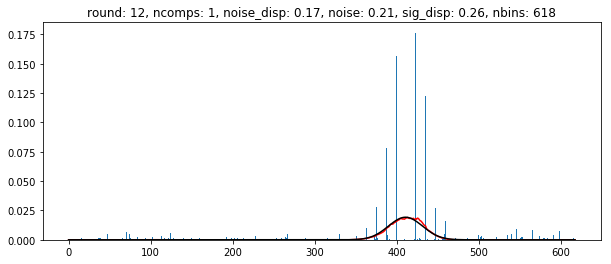

sim 10/500000, loss: 0.1249, losses_av: 0.1641, tv: 0.00454, tv_trend: 0.00755,  shrink: 0.0278, ll: 0.0090, KL: 0.1005, nbins: 204
sim 20/500000, loss: 0.2371, losses_av: 0.1638, tv: 0.00454, tv_trend: 0.00754,  shrink: 0.0279, ll: 0.0090, KL: 0.1003, nbins: 480
sim 30/500000, loss: 0.0988, losses_av: 0.1636, tv: 0.00454, tv_trend: 0.00753,  shrink: 0.0278, ll: 0.0090, KL: 0.1001, nbins: 385
sim 40/500000, loss: 0.0765, losses_av: 0.1633, tv: 0.00452, tv_trend: 0.00751,  shrink: 0.0278, ll: 0.0090, KL: 0.0999, nbins: 522
sim 50/500000, loss: 0.1017, losses_av: 0.1629, tv: 0.00451, tv_trend: 0.00748,  shrink: 0.0278, ll: 0.0089, KL: 0.0998, nbins: 489
sim 60/500000, loss: 0.1205, losses_av: 0.1630, tv: 0.00452, tv_trend: 0.00748,  shrink: 0.0279, ll: 0.0090, KL: 0.0997, nbins: 440
sim 70/500000, loss: 0.0850, losses_av: 0.1633, tv: 0.00454, tv_trend: 0.00750,  shrink: 0.0279, ll: 0.0090, KL: 0.0997, nbins: 330
sim 80/500000, loss: 0.1377, losses_av: 0.1628, tv: 0.00451, tv_trend: 0.007

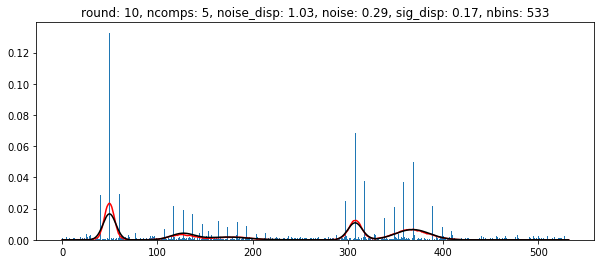

sim 110/500000, loss: 0.0585, losses_av: 0.1629, tv: 0.00450, tv_trend: 0.00742,  shrink: 0.0279, ll: 0.0090, KL: 0.0994, nbins: 348
sim 120/500000, loss: 0.2080, losses_av: 0.1629, tv: 0.00450, tv_trend: 0.00740,  shrink: 0.0279, ll: 0.0091, KL: 0.0993, nbins: 102
sim 130/500000, loss: 0.1252, losses_av: 0.1625, tv: 0.00448, tv_trend: 0.00736,  shrink: 0.0279, ll: 0.0090, KL: 0.0991, nbins: 32
sim 140/500000, loss: 0.0470, losses_av: 0.1623, tv: 0.00447, tv_trend: 0.00734,  shrink: 0.0279, ll: 0.0090, KL: 0.0989, nbins: 366
sim 150/500000, loss: 0.0920, losses_av: 0.1621, tv: 0.00446, tv_trend: 0.00732,  shrink: 0.0279, ll: 0.0090, KL: 0.0988, nbins: 429
sim 160/500000, loss: 0.3767, losses_av: 0.1620, tv: 0.00447, tv_trend: 0.00733,  shrink: 0.0279, ll: 0.0090, KL: 0.0986, nbins: 372
sim 170/500000, loss: 0.1865, losses_av: 0.1619, tv: 0.00447, tv_trend: 0.00732,  shrink: 0.0279, ll: 0.0091, KL: 0.0985, nbins: 514
sim 180/500000, loss: 0.0889, losses_av: 0.1617, tv: 0.00447, tv_trend

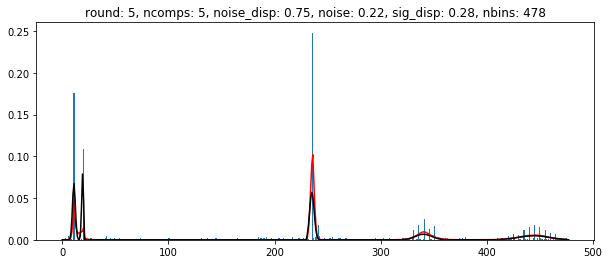

sim 210/500000, loss: 0.1572, losses_av: 0.1617, tv: 0.00445, tv_trend: 0.00727,  shrink: 0.0279, ll: 0.0091, KL: 0.0985, nbins: 266
sim 220/500000, loss: 0.0789, losses_av: 0.1616, tv: 0.00445, tv_trend: 0.00726,  shrink: 0.0279, ll: 0.0091, KL: 0.0983, nbins: 306
sim 230/500000, loss: 0.0933, losses_av: 0.1618, tv: 0.00446, tv_trend: 0.00726,  shrink: 0.0279, ll: 0.0091, KL: 0.0983, nbins: 43
sim 240/500000, loss: 0.2311, losses_av: 0.1617, tv: 0.00445, tv_trend: 0.00725,  shrink: 0.0278, ll: 0.0091, KL: 0.0983, nbins: 429
sim 250/500000, loss: 0.0900, losses_av: 0.1613, tv: 0.00443, tv_trend: 0.00721,  shrink: 0.0278, ll: 0.0091, KL: 0.0981, nbins: 555
sim 260/500000, loss: 0.3038, losses_av: 0.1621, tv: 0.00446, tv_trend: 0.00726,  shrink: 0.0279, ll: 0.0092, KL: 0.0982, nbins: 171
sim 270/500000, loss: 0.0895, losses_av: 0.1618, tv: 0.00445, tv_trend: 0.00723,  shrink: 0.0279, ll: 0.0092, KL: 0.0981, nbins: 371
sim 280/500000, loss: 0.0519, losses_av: 0.1617, tv: 0.00445, tv_trend

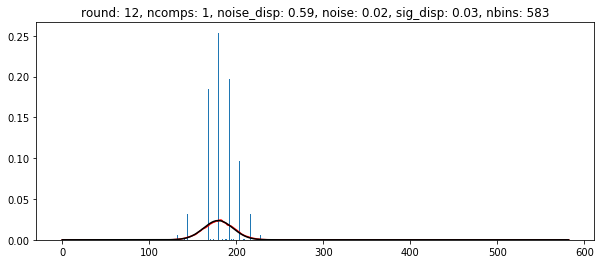

sim 310/500000, loss: 0.1906, losses_av: 0.1620, tv: 0.00446, tv_trend: 0.00725,  shrink: 0.0278, ll: 0.0093, KL: 0.0978, nbins: 55
sim 320/500000, loss: 0.2250, losses_av: 0.1619, tv: 0.00446, tv_trend: 0.00724,  shrink: 0.0279, ll: 0.0093, KL: 0.0978, nbins: 62
sim 330/500000, loss: 0.0996, losses_av: 0.1614, tv: 0.00445, tv_trend: 0.00721,  shrink: 0.0279, ll: 0.0092, KL: 0.0976, nbins: 42
sim 340/500000, loss: 0.0574, losses_av: 0.1611, tv: 0.00443, tv_trend: 0.00719,  shrink: 0.0280, ll: 0.0092, KL: 0.0974, nbins: 472
sim 350/500000, loss: 0.0746, losses_av: 0.1612, tv: 0.00443, tv_trend: 0.00717,  shrink: 0.0280, ll: 0.0092, KL: 0.0974, nbins: 329
sim 360/500000, loss: 0.1678, losses_av: 0.1614, tv: 0.00445, tv_trend: 0.00720,  shrink: 0.0281, ll: 0.0093, KL: 0.0974, nbins: 108
sim 370/500000, loss: 0.3010, losses_av: 0.1614, tv: 0.00446, tv_trend: 0.00721,  shrink: 0.0281, ll: 0.0093, KL: 0.0973, nbins: 518
sim 380/500000, loss: 0.2252, losses_av: 0.1612, tv: 0.00446, tv_trend: 

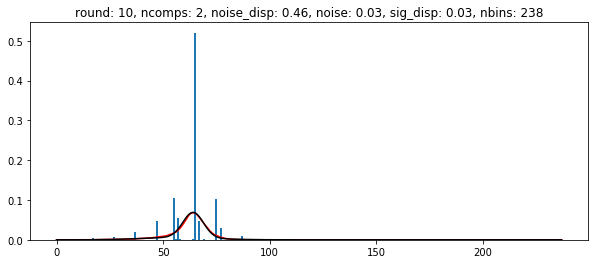

sim 410/500000, loss: 0.1932, losses_av: 0.1613, tv: 0.00450, tv_trend: 0.00726,  shrink: 0.0281, ll: 0.0093, KL: 0.0970, nbins: 50
sim 420/500000, loss: 0.2102, losses_av: 0.1615, tv: 0.00450, tv_trend: 0.00725,  shrink: 0.0282, ll: 0.0094, KL: 0.0970, nbins: 530
sim 430/500000, loss: 0.3217, losses_av: 0.1615, tv: 0.00451, tv_trend: 0.00726,  shrink: 0.0282, ll: 0.0094, KL: 0.0969, nbins: 257
sim 440/500000, loss: 0.1259, losses_av: 0.1615, tv: 0.00450, tv_trend: 0.00724,  shrink: 0.0282, ll: 0.0094, KL: 0.0970, nbins: 38
sim 450/500000, loss: 0.3263, losses_av: 0.1620, tv: 0.00450, tv_trend: 0.00724,  shrink: 0.0282, ll: 0.0094, KL: 0.0971, nbins: 43
sim 460/500000, loss: 0.1442, losses_av: 0.1617, tv: 0.00449, tv_trend: 0.00722,  shrink: 0.0282, ll: 0.0094, KL: 0.0969, nbins: 426
sim 470/500000, loss: 0.1077, losses_av: 0.1619, tv: 0.00450, tv_trend: 0.00722,  shrink: 0.0283, ll: 0.0095, KL: 0.0969, nbins: 110
sim 480/500000, loss: 0.1275, losses_av: 0.1620, tv: 0.00450, tv_trend: 

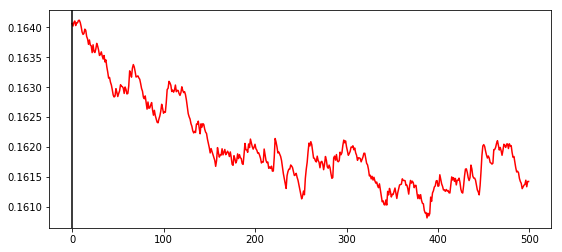

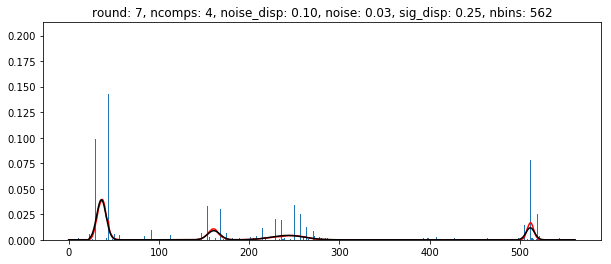

sim 510/500000, loss: 0.1007, losses_av: 0.1614, tv: 0.00449, tv_trend: 0.00720,  shrink: 0.0283, ll: 0.0095, KL: 0.0964, nbins: 478
sim 520/500000, loss: 0.1409, losses_av: 0.1610, tv: 0.00447, tv_trend: 0.00716,  shrink: 0.0283, ll: 0.0094, KL: 0.0962, nbins: 158
sim 530/500000, loss: 0.1941, losses_av: 0.1613, tv: 0.00451, tv_trend: 0.00724,  shrink: 0.0284, ll: 0.0095, KL: 0.0961, nbins: 267
sim 540/500000, loss: 0.2209, losses_av: 0.1610, tv: 0.00451, tv_trend: 0.00724,  shrink: 0.0284, ll: 0.0094, KL: 0.0960, nbins: 131
sim 550/500000, loss: 0.1099, losses_av: 0.1609, tv: 0.00451, tv_trend: 0.00722,  shrink: 0.0284, ll: 0.0094, KL: 0.0959, nbins: 393
sim 560/500000, loss: 0.1810, losses_av: 0.1606, tv: 0.00450, tv_trend: 0.00721,  shrink: 0.0284, ll: 0.0094, KL: 0.0957, nbins: 371
sim 570/500000, loss: 0.4046, losses_av: 0.1606, tv: 0.00449, tv_trend: 0.00719,  shrink: 0.0284, ll: 0.0095, KL: 0.0956, nbins: 132
sim 580/500000, loss: 0.1381, losses_av: 0.1607, tv: 0.00450, tv_tren

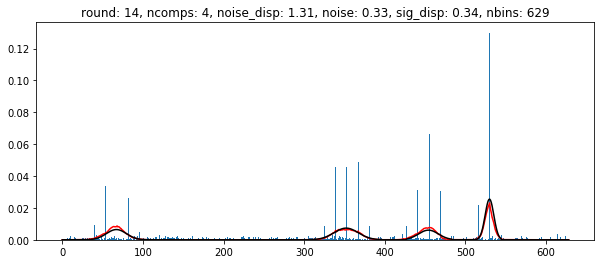

sim 610/500000, loss: 0.0684, losses_av: 0.1608, tv: 0.00452, tv_trend: 0.00721,  shrink: 0.0285, ll: 0.0095, KL: 0.0958, nbins: 520
sim 620/500000, loss: 0.1246, losses_av: 0.1609, tv: 0.00453, tv_trend: 0.00724,  shrink: 0.0286, ll: 0.0095, KL: 0.0957, nbins: 138
sim 630/500000, loss: 0.1235, losses_av: 0.1606, tv: 0.00453, tv_trend: 0.00723,  shrink: 0.0285, ll: 0.0095, KL: 0.0955, nbins: 220
sim 640/500000, loss: 0.1559, losses_av: 0.1607, tv: 0.00453, tv_trend: 0.00723,  shrink: 0.0285, ll: 0.0095, KL: 0.0954, nbins: 166
sim 650/500000, loss: 0.0804, losses_av: 0.1604, tv: 0.00452, tv_trend: 0.00722,  shrink: 0.0285, ll: 0.0095, KL: 0.0952, nbins: 587
sim 660/500000, loss: 0.1714, losses_av: 0.1602, tv: 0.00451, tv_trend: 0.00720,  shrink: 0.0285, ll: 0.0095, KL: 0.0952, nbins: 414
sim 670/500000, loss: 0.0932, losses_av: 0.1602, tv: 0.00451, tv_trend: 0.00719,  shrink: 0.0285, ll: 0.0095, KL: 0.0951, nbins: 493
sim 680/500000, loss: 0.2225, losses_av: 0.1604, tv: 0.00450, tv_tren

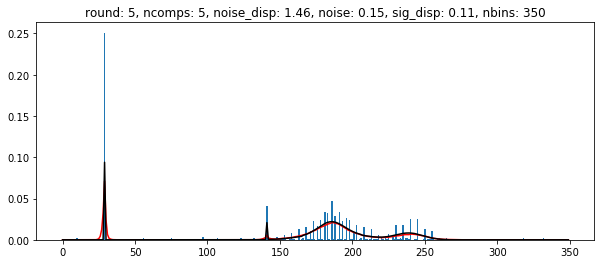

sim 710/500000, loss: 0.0708, losses_av: 0.1603, tv: 0.00450, tv_trend: 0.00716,  shrink: 0.0286, ll: 0.0096, KL: 0.0949, nbins: 274
sim 720/500000, loss: 0.2410, losses_av: 0.1602, tv: 0.00450, tv_trend: 0.00716,  shrink: 0.0286, ll: 0.0096, KL: 0.0948, nbins: 305
sim 730/500000, loss: 0.1832, losses_av: 0.1604, tv: 0.00452, tv_trend: 0.00718,  shrink: 0.0286, ll: 0.0096, KL: 0.0949, nbins: 577
sim 740/500000, loss: 0.0856, losses_av: 0.1601, tv: 0.00451, tv_trend: 0.00718,  shrink: 0.0286, ll: 0.0096, KL: 0.0947, nbins: 438
sim 750/500000, loss: 0.1479, losses_av: 0.1601, tv: 0.00450, tv_trend: 0.00715,  shrink: 0.0285, ll: 0.0096, KL: 0.0947, nbins: 212
sim 760/500000, loss: 0.1722, losses_av: 0.1603, tv: 0.00450, tv_trend: 0.00715,  shrink: 0.0285, ll: 0.0097, KL: 0.0948, nbins: 77
sim 770/500000, loss: 0.1460, losses_av: 0.1603, tv: 0.00450, tv_trend: 0.00715,  shrink: 0.0285, ll: 0.0097, KL: 0.0947, nbins: 519
sim 780/500000, loss: 0.1049, losses_av: 0.1600, tv: 0.00449, tv_trend

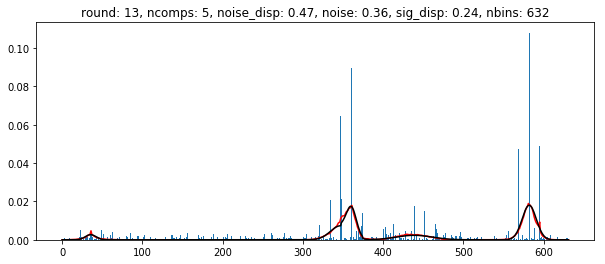

sim 810/500000, loss: 0.1251, losses_av: 0.1594, tv: 0.00444, tv_trend: 0.00704,  shrink: 0.0284, ll: 0.0096, KL: 0.0943, nbins: 371
sim 820/500000, loss: 0.0833, losses_av: 0.1590, tv: 0.00443, tv_trend: 0.00701,  shrink: 0.0284, ll: 0.0096, KL: 0.0941, nbins: 158
sim 830/500000, loss: 0.1897, losses_av: 0.1589, tv: 0.00445, tv_trend: 0.00704,  shrink: 0.0286, ll: 0.0096, KL: 0.0940, nbins: 23
sim 840/500000, loss: 0.1044, losses_av: 0.1589, tv: 0.00444, tv_trend: 0.00702,  shrink: 0.0286, ll: 0.0096, KL: 0.0940, nbins: 513
sim 850/500000, loss: 0.1939, losses_av: 0.1586, tv: 0.00443, tv_trend: 0.00700,  shrink: 0.0287, ll: 0.0096, KL: 0.0939, nbins: 71
sim 860/500000, loss: 0.0366, losses_av: 0.1581, tv: 0.00442, tv_trend: 0.00696,  shrink: 0.0287, ll: 0.0095, KL: 0.0936, nbins: 501
sim 870/500000, loss: 0.0607, losses_av: 0.1578, tv: 0.00440, tv_trend: 0.00692,  shrink: 0.0287, ll: 0.0095, KL: 0.0935, nbins: 433
sim 880/500000, loss: 0.1431, losses_av: 0.1588, tv: 0.00440, tv_trend:

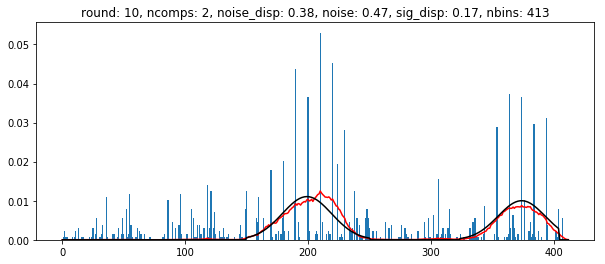

sim 910/500000, loss: 0.1121, losses_av: 0.1586, tv: 0.00437, tv_trend: 0.00684,  shrink: 0.0288, ll: 0.0096, KL: 0.0938, nbins: 383
sim 920/500000, loss: 0.1428, losses_av: 0.1590, tv: 0.00439, tv_trend: 0.00688,  shrink: 0.0288, ll: 0.0097, KL: 0.0938, nbins: 122
sim 930/500000, loss: 0.2196, losses_av: 0.1591, tv: 0.00440, tv_trend: 0.00689,  shrink: 0.0289, ll: 0.0097, KL: 0.0937, nbins: 533
sim 940/500000, loss: 0.0763, losses_av: 0.1588, tv: 0.00440, tv_trend: 0.00688,  shrink: 0.0288, ll: 0.0097, KL: 0.0936, nbins: 274
sim 950/500000, loss: 0.0846, losses_av: 0.1586, tv: 0.00439, tv_trend: 0.00687,  shrink: 0.0288, ll: 0.0097, KL: 0.0935, nbins: 132
sim 960/500000, loss: 0.1686, losses_av: 0.1586, tv: 0.00440, tv_trend: 0.00687,  shrink: 0.0288, ll: 0.0097, KL: 0.0935, nbins: 69
sim 970/500000, loss: 0.1142, losses_av: 0.1589, tv: 0.00442, tv_trend: 0.00690,  shrink: 0.0288, ll: 0.0097, KL: 0.0936, nbins: 317
sim 980/500000, loss: 0.0768, losses_av: 0.1589, tv: 0.00442, tv_trend

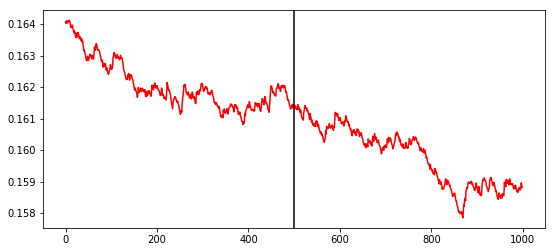

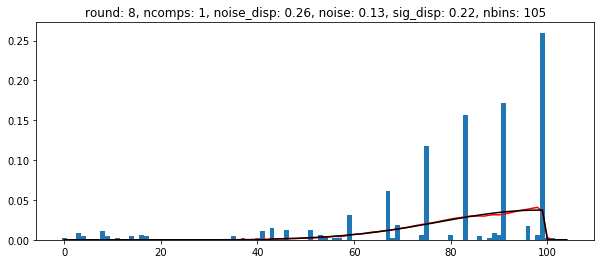

sim 1010/500000, loss: 0.2214, losses_av: 0.1584, tv: 0.00443, tv_trend: 0.00689,  shrink: 0.0290, ll: 0.0097, KL: 0.0934, nbins: 292
sim 1020/500000, loss: 0.2028, losses_av: 0.1590, tv: 0.00444, tv_trend: 0.00691,  shrink: 0.0290, ll: 0.0098, KL: 0.0935, nbins: 119
sim 1030/500000, loss: 0.2052, losses_av: 0.1593, tv: 0.00446, tv_trend: 0.00693,  shrink: 0.0291, ll: 0.0098, KL: 0.0936, nbins: 376
sim 1040/500000, loss: 0.0817, losses_av: 0.1591, tv: 0.00444, tv_trend: 0.00690,  shrink: 0.0290, ll: 0.0098, KL: 0.0936, nbins: 341
sim 1050/500000, loss: 0.0560, losses_av: 0.1589, tv: 0.00444, tv_trend: 0.00690,  shrink: 0.0290, ll: 0.0098, KL: 0.0934, nbins: 272
sim 1060/500000, loss: 0.1070, losses_av: 0.1588, tv: 0.00444, tv_trend: 0.00690,  shrink: 0.0290, ll: 0.0098, KL: 0.0933, nbins: 408
sim 1070/500000, loss: 0.1454, losses_av: 0.1585, tv: 0.00442, tv_trend: 0.00687,  shrink: 0.0289, ll: 0.0098, KL: 0.0932, nbins: 562
sim 1080/500000, loss: 0.1300, losses_av: 0.1580, tv: 0.00440,

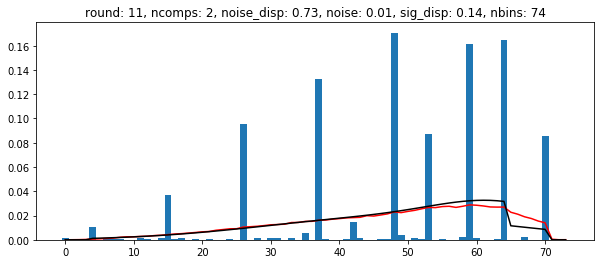

sim 1110/500000, loss: 0.0626, losses_av: 0.1580, tv: 0.00437, tv_trend: 0.00676,  shrink: 0.0288, ll: 0.0097, KL: 0.0930, nbins: 332
sim 1120/500000, loss: 0.0668, losses_av: 0.1582, tv: 0.00438, tv_trend: 0.00678,  shrink: 0.0288, ll: 0.0098, KL: 0.0930, nbins: 300
sim 1130/500000, loss: 0.0635, losses_av: 0.1582, tv: 0.00439, tv_trend: 0.00680,  shrink: 0.0288, ll: 0.0098, KL: 0.0931, nbins: 400
sim 1140/500000, loss: 0.1705, losses_av: 0.1578, tv: 0.00438, tv_trend: 0.00677,  shrink: 0.0288, ll: 0.0097, KL: 0.0929, nbins: 501
sim 1150/500000, loss: 0.0917, losses_av: 0.1580, tv: 0.00439, tv_trend: 0.00679,  shrink: 0.0288, ll: 0.0097, KL: 0.0930, nbins: 416
sim 1160/500000, loss: 0.1767, losses_av: 0.1583, tv: 0.00439, tv_trend: 0.00679,  shrink: 0.0288, ll: 0.0098, KL: 0.0931, nbins: 496
sim 1170/500000, loss: 0.2882, losses_av: 0.1587, tv: 0.00441, tv_trend: 0.00682,  shrink: 0.0288, ll: 0.0098, KL: 0.0932, nbins: 242
sim 1180/500000, loss: 0.2489, losses_av: 0.1587, tv: 0.00440,

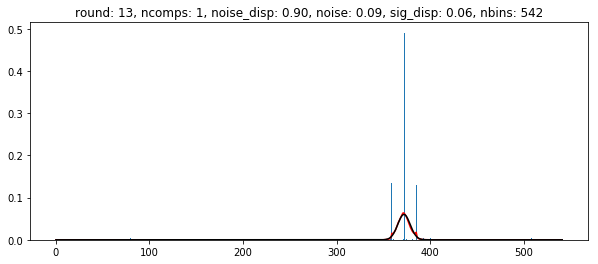

sim 1210/500000, loss: 0.1529, losses_av: 0.1581, tv: 0.00439, tv_trend: 0.00679,  shrink: 0.0288, ll: 0.0098, KL: 0.0928, nbins: 441
sim 1220/500000, loss: 0.0508, losses_av: 0.1581, tv: 0.00439, tv_trend: 0.00679,  shrink: 0.0288, ll: 0.0098, KL: 0.0927, nbins: 109
sim 1230/500000, loss: 0.1438, losses_av: 0.1580, tv: 0.00438, tv_trend: 0.00676,  shrink: 0.0289, ll: 0.0098, KL: 0.0927, nbins: 12
sim 1240/500000, loss: 0.1339, losses_av: 0.1579, tv: 0.00437, tv_trend: 0.00674,  shrink: 0.0288, ll: 0.0098, KL: 0.0927, nbins: 556
sim 1250/500000, loss: 0.1032, losses_av: 0.1577, tv: 0.00436, tv_trend: 0.00671,  shrink: 0.0288, ll: 0.0098, KL: 0.0926, nbins: 215
sim 1260/500000, loss: 0.0964, losses_av: 0.1582, tv: 0.00435, tv_trend: 0.00670,  shrink: 0.0288, ll: 0.0098, KL: 0.0928, nbins: 307
sim 1270/500000, loss: 0.3016, losses_av: 0.1580, tv: 0.00435, tv_trend: 0.00670,  shrink: 0.0288, ll: 0.0098, KL: 0.0927, nbins: 84
sim 1280/500000, loss: 0.1343, losses_av: 0.1580, tv: 0.00435, t

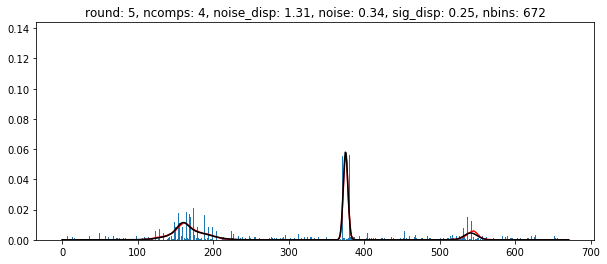

sim 1310/500000, loss: 0.2874, losses_av: 0.1575, tv: 0.00434, tv_trend: 0.00668,  shrink: 0.0288, ll: 0.0098, KL: 0.0924, nbins: 215
sim 1320/500000, loss: 0.0844, losses_av: 0.1573, tv: 0.00434, tv_trend: 0.00666,  shrink: 0.0288, ll: 0.0098, KL: 0.0923, nbins: 84
sim 1330/500000, loss: 0.1205, losses_av: 0.1570, tv: 0.00432, tv_trend: 0.00664,  shrink: 0.0288, ll: 0.0097, KL: 0.0922, nbins: 93
sim 1340/500000, loss: 0.1530, losses_av: 0.1567, tv: 0.00431, tv_trend: 0.00662,  shrink: 0.0288, ll: 0.0097, KL: 0.0921, nbins: 385
sim 1350/500000, loss: 0.1165, losses_av: 0.1567, tv: 0.00431, tv_trend: 0.00661,  shrink: 0.0288, ll: 0.0098, KL: 0.0921, nbins: 81
sim 1360/500000, loss: 0.1871, losses_av: 0.1566, tv: 0.00430, tv_trend: 0.00660,  shrink: 0.0287, ll: 0.0098, KL: 0.0919, nbins: 76
sim 1370/500000, loss: 0.1969, losses_av: 0.1564, tv: 0.00429, tv_trend: 0.00658,  shrink: 0.0287, ll: 0.0097, KL: 0.0919, nbins: 354
sim 1380/500000, loss: 0.2504, losses_av: 0.1564, tv: 0.00428, tv_

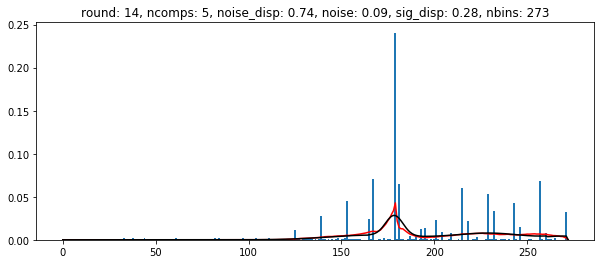

sim 1410/500000, loss: 0.0840, losses_av: 0.1564, tv: 0.00426, tv_trend: 0.00652,  shrink: 0.0287, ll: 0.0097, KL: 0.0919, nbins: 161
sim 1420/500000, loss: 0.0598, losses_av: 0.1562, tv: 0.00425, tv_trend: 0.00651,  shrink: 0.0286, ll: 0.0097, KL: 0.0918, nbins: 458
sim 1430/500000, loss: 0.2182, losses_av: 0.1559, tv: 0.00425, tv_trend: 0.00650,  shrink: 0.0286, ll: 0.0097, KL: 0.0917, nbins: 475
sim 1440/500000, loss: 0.0936, losses_av: 0.1559, tv: 0.00425, tv_trend: 0.00650,  shrink: 0.0286, ll: 0.0097, KL: 0.0916, nbins: 309
sim 1450/500000, loss: 0.1349, losses_av: 0.1555, tv: 0.00424, tv_trend: 0.00647,  shrink: 0.0285, ll: 0.0097, KL: 0.0915, nbins: 156
sim 1460/500000, loss: 0.1384, losses_av: 0.1559, tv: 0.00423, tv_trend: 0.00646,  shrink: 0.0286, ll: 0.0097, KL: 0.0916, nbins: 73
sim 1470/500000, loss: 0.0445, losses_av: 0.1556, tv: 0.00421, tv_trend: 0.00643,  shrink: 0.0286, ll: 0.0097, KL: 0.0915, nbins: 573
sim 1480/500000, loss: 0.0970, losses_av: 0.1557, tv: 0.00422, 

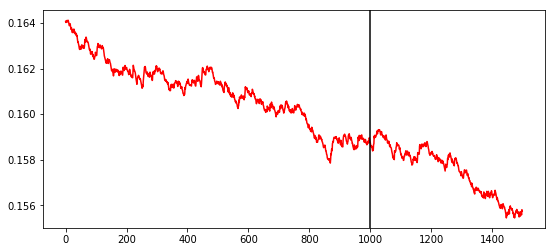

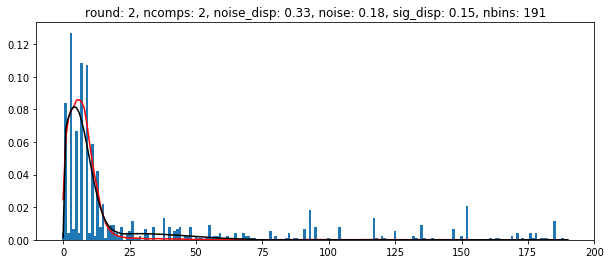

sim 1510/500000, loss: 0.1025, losses_av: 0.1559, tv: 0.00425, tv_trend: 0.00650,  shrink: 0.0285, ll: 0.0098, KL: 0.0914, nbins: 497
sim 1520/500000, loss: 0.1029, losses_av: 0.1556, tv: 0.00425, tv_trend: 0.00649,  shrink: 0.0286, ll: 0.0097, KL: 0.0913, nbins: 307
sim 1530/500000, loss: 0.1191, losses_av: 0.1557, tv: 0.00425, tv_trend: 0.00650,  shrink: 0.0286, ll: 0.0097, KL: 0.0912, nbins: 91
sim 1540/500000, loss: 0.1696, losses_av: 0.1556, tv: 0.00425, tv_trend: 0.00650,  shrink: 0.0285, ll: 0.0097, KL: 0.0912, nbins: 371
sim 1550/500000, loss: 0.0729, losses_av: 0.1551, tv: 0.00424, tv_trend: 0.00648,  shrink: 0.0286, ll: 0.0097, KL: 0.0910, nbins: 103
sim 1560/500000, loss: 0.1601, losses_av: 0.1558, tv: 0.00424, tv_trend: 0.00649,  shrink: 0.0286, ll: 0.0098, KL: 0.0912, nbins: 224
sim 1570/500000, loss: 0.0847, losses_av: 0.1557, tv: 0.00425, tv_trend: 0.00651,  shrink: 0.0287, ll: 0.0098, KL: 0.0911, nbins: 585
sim 1580/500000, loss: 0.2884, losses_av: 0.1561, tv: 0.00426, 

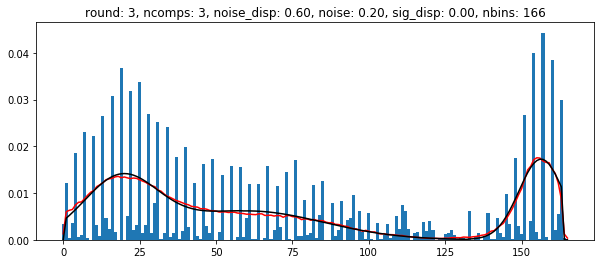

sim 1610/500000, loss: 0.2223, losses_av: 0.1565, tv: 0.00430, tv_trend: 0.00660,  shrink: 0.0287, ll: 0.0099, KL: 0.0913, nbins: 587
sim 1620/500000, loss: 0.1711, losses_av: 0.1567, tv: 0.00429, tv_trend: 0.00658,  shrink: 0.0288, ll: 0.0099, KL: 0.0914, nbins: 187
sim 1630/500000, loss: 0.1907, losses_av: 0.1573, tv: 0.00431, tv_trend: 0.00660,  shrink: 0.0290, ll: 0.0099, KL: 0.0917, nbins: 10
sim 1640/500000, loss: 0.2020, losses_av: 0.1571, tv: 0.00432, tv_trend: 0.00660,  shrink: 0.0291, ll: 0.0099, KL: 0.0916, nbins: 248
sim 1650/500000, loss: 0.2593, losses_av: 0.1573, tv: 0.00432, tv_trend: 0.00661,  shrink: 0.0291, ll: 0.0099, KL: 0.0917, nbins: 555
sim 1660/500000, loss: 0.0676, losses_av: 0.1569, tv: 0.00431, tv_trend: 0.00659,  shrink: 0.0291, ll: 0.0099, KL: 0.0915, nbins: 563
sim 1670/500000, loss: 0.1496, losses_av: 0.1566, tv: 0.00430, tv_trend: 0.00657,  shrink: 0.0291, ll: 0.0099, KL: 0.0914, nbins: 46
sim 1680/500000, loss: 0.0708, losses_av: 0.1564, tv: 0.00429, t

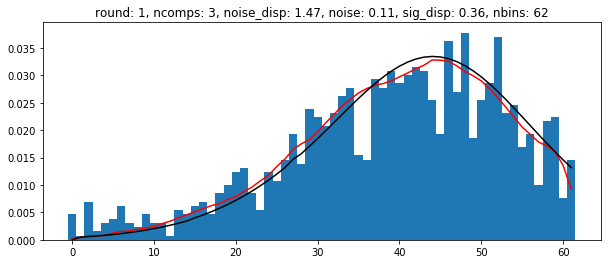

sim 1710/500000, loss: 0.1380, losses_av: 0.1554, tv: 0.00424, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0098, KL: 0.0910, nbins: 259
sim 1720/500000, loss: 0.0980, losses_av: 0.1554, tv: 0.00424, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0098, KL: 0.0910, nbins: 581
sim 1730/500000, loss: 0.4087, losses_av: 0.1555, tv: 0.00423, tv_trend: 0.00644,  shrink: 0.0289, ll: 0.0098, KL: 0.0911, nbins: 137
sim 1740/500000, loss: 0.0599, losses_av: 0.1553, tv: 0.00423, tv_trend: 0.00642,  shrink: 0.0289, ll: 0.0098, KL: 0.0910, nbins: 555
sim 1750/500000, loss: 0.0659, losses_av: 0.1548, tv: 0.00421, tv_trend: 0.00638,  shrink: 0.0289, ll: 0.0098, KL: 0.0907, nbins: 452
sim 1760/500000, loss: 0.1186, losses_av: 0.1546, tv: 0.00420, tv_trend: 0.00637,  shrink: 0.0289, ll: 0.0097, KL: 0.0906, nbins: 97
sim 1770/500000, loss: 0.2000, losses_av: 0.1545, tv: 0.00419, tv_trend: 0.00636,  shrink: 0.0288, ll: 0.0097, KL: 0.0905, nbins: 115
sim 1780/500000, loss: 0.1477, losses_av: 0.1547, tv: 0.00420, 

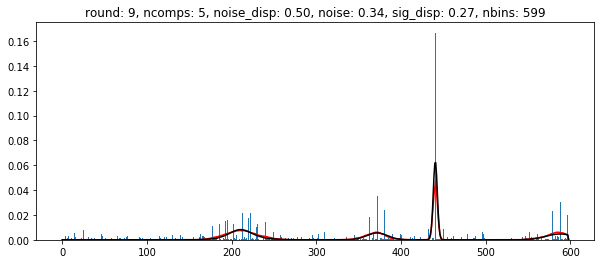

sim 1810/500000, loss: 0.0845, losses_av: 0.1548, tv: 0.00422, tv_trend: 0.00640,  shrink: 0.0289, ll: 0.0098, KL: 0.0905, nbins: 354
sim 1820/500000, loss: 0.4192, losses_av: 0.1547, tv: 0.00421, tv_trend: 0.00639,  shrink: 0.0289, ll: 0.0098, KL: 0.0906, nbins: 223
sim 1830/500000, loss: 0.0652, losses_av: 0.1545, tv: 0.00421, tv_trend: 0.00637,  shrink: 0.0289, ll: 0.0098, KL: 0.0904, nbins: 591
sim 1840/500000, loss: 0.1764, losses_av: 0.1545, tv: 0.00420, tv_trend: 0.00636,  shrink: 0.0288, ll: 0.0098, KL: 0.0904, nbins: 253
sim 1850/500000, loss: 0.0764, losses_av: 0.1544, tv: 0.00419, tv_trend: 0.00634,  shrink: 0.0288, ll: 0.0097, KL: 0.0905, nbins: 584
sim 1860/500000, loss: 0.0583, losses_av: 0.1546, tv: 0.00419, tv_trend: 0.00634,  shrink: 0.0288, ll: 0.0098, KL: 0.0905, nbins: 394
sim 1870/500000, loss: 0.1775, losses_av: 0.1551, tv: 0.00421, tv_trend: 0.00639,  shrink: 0.0288, ll: 0.0098, KL: 0.0907, nbins: 401
sim 1880/500000, loss: 0.2434, losses_av: 0.1555, tv: 0.00422,

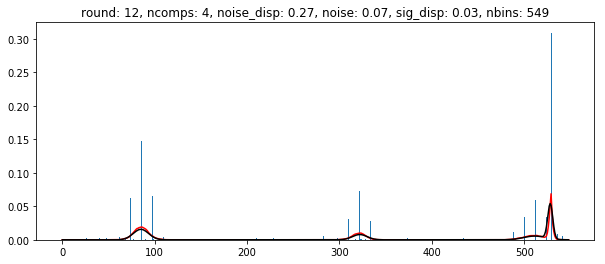

sim 1910/500000, loss: 0.1127, losses_av: 0.1553, tv: 0.00424, tv_trend: 0.00645,  shrink: 0.0288, ll: 0.0098, KL: 0.0907, nbins: 447
sim 1920/500000, loss: 0.2553, losses_av: 0.1554, tv: 0.00424, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0098, KL: 0.0908, nbins: 296
sim 1930/500000, loss: 0.1791, losses_av: 0.1558, tv: 0.00425, tv_trend: 0.00648,  shrink: 0.0287, ll: 0.0099, KL: 0.0909, nbins: 541
sim 1940/500000, loss: 0.0705, losses_av: 0.1559, tv: 0.00424, tv_trend: 0.00647,  shrink: 0.0287, ll: 0.0099, KL: 0.0910, nbins: 289
sim 1950/500000, loss: 0.0892, losses_av: 0.1560, tv: 0.00424, tv_trend: 0.00647,  shrink: 0.0287, ll: 0.0099, KL: 0.0910, nbins: 556
sim 1960/500000, loss: 0.1924, losses_av: 0.1557, tv: 0.00423, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0098, KL: 0.0910, nbins: 183
sim 1970/500000, loss: 0.0761, losses_av: 0.1552, tv: 0.00422, tv_trend: 0.00643,  shrink: 0.0287, ll: 0.0098, KL: 0.0907, nbins: 237
sim 1980/500000, loss: 0.1269, losses_av: 0.1552, tv: 0.00421,

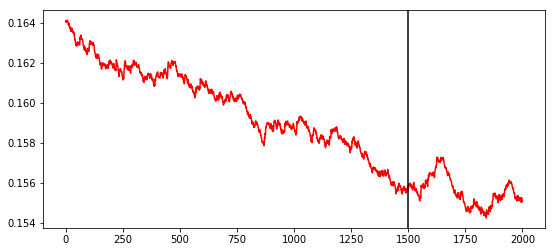

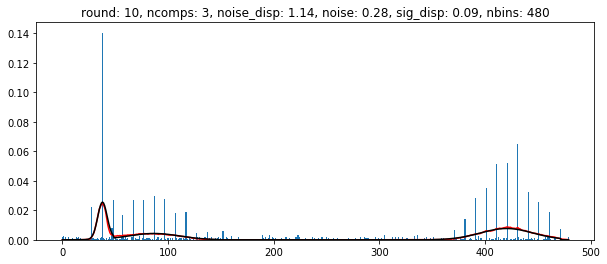

sim 2010/500000, loss: 0.1110, losses_av: 0.1553, tv: 0.00420, tv_trend: 0.00640,  shrink: 0.0287, ll: 0.0099, KL: 0.0906, nbins: 59
sim 2020/500000, loss: 0.1709, losses_av: 0.1558, tv: 0.00422, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0099, KL: 0.0908, nbins: 526
sim 2030/500000, loss: 0.3414, losses_av: 0.1559, tv: 0.00422, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0099, KL: 0.0908, nbins: 85
sim 2040/500000, loss: 0.0884, losses_av: 0.1557, tv: 0.00420, tv_trend: 0.00642,  shrink: 0.0286, ll: 0.0099, KL: 0.0907, nbins: 476
sim 2050/500000, loss: 0.1924, losses_av: 0.1554, tv: 0.00419, tv_trend: 0.00640,  shrink: 0.0286, ll: 0.0099, KL: 0.0906, nbins: 428
sim 2060/500000, loss: 0.1075, losses_av: 0.1558, tv: 0.00420, tv_trend: 0.00641,  shrink: 0.0286, ll: 0.0099, KL: 0.0906, nbins: 441
sim 2070/500000, loss: 0.1883, losses_av: 0.1557, tv: 0.00420, tv_trend: 0.00640,  shrink: 0.0286, ll: 0.0099, KL: 0.0906, nbins: 475
sim 2080/500000, loss: 0.1375, losses_av: 0.1559, tv: 0.00421, t

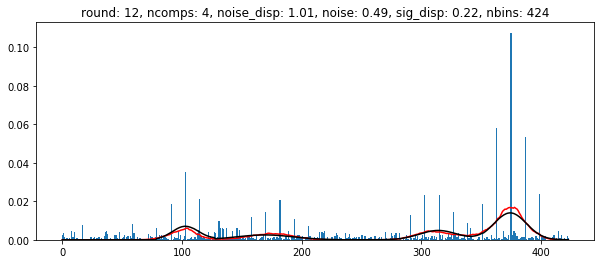

sim 2110/500000, loss: 0.1572, losses_av: 0.1561, tv: 0.00421, tv_trend: 0.00645,  shrink: 0.0285, ll: 0.0100, KL: 0.0906, nbins: 314
sim 2120/500000, loss: 0.0594, losses_av: 0.1556, tv: 0.00420, tv_trend: 0.00641,  shrink: 0.0286, ll: 0.0099, KL: 0.0904, nbins: 316
sim 2130/500000, loss: 0.0547, losses_av: 0.1556, tv: 0.00419, tv_trend: 0.00641,  shrink: 0.0286, ll: 0.0099, KL: 0.0904, nbins: 461
sim 2140/500000, loss: 0.2754, losses_av: 0.1556, tv: 0.00419, tv_trend: 0.00640,  shrink: 0.0286, ll: 0.0099, KL: 0.0905, nbins: 323
sim 2150/500000, loss: 0.1180, losses_av: 0.1556, tv: 0.00419, tv_trend: 0.00641,  shrink: 0.0286, ll: 0.0099, KL: 0.0905, nbins: 121
sim 2160/500000, loss: 0.1464, losses_av: 0.1555, tv: 0.00419, tv_trend: 0.00639,  shrink: 0.0286, ll: 0.0099, KL: 0.0905, nbins: 276
sim 2170/500000, loss: 0.2187, losses_av: 0.1556, tv: 0.00418, tv_trend: 0.00637,  shrink: 0.0286, ll: 0.0099, KL: 0.0905, nbins: 385
sim 2180/500000, loss: 0.2995, losses_av: 0.1562, tv: 0.00420,

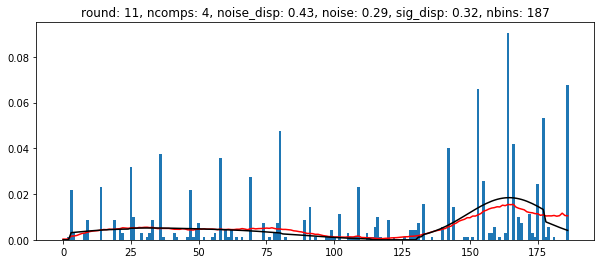

sim 2210/500000, loss: 0.3109, losses_av: 0.1562, tv: 0.00421, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0100, KL: 0.0907, nbins: 64
sim 2220/500000, loss: 0.1882, losses_av: 0.1562, tv: 0.00422, tv_trend: 0.00643,  shrink: 0.0287, ll: 0.0100, KL: 0.0907, nbins: 389
sim 2230/500000, loss: 0.1969, losses_av: 0.1569, tv: 0.00424, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0101, KL: 0.0909, nbins: 525
sim 2240/500000, loss: 0.0890, losses_av: 0.1568, tv: 0.00422, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0101, KL: 0.0908, nbins: 292
sim 2250/500000, loss: 0.1918, losses_av: 0.1569, tv: 0.00421, tv_trend: 0.00641,  shrink: 0.0288, ll: 0.0101, KL: 0.0908, nbins: 586
sim 2260/500000, loss: 0.2267, losses_av: 0.1570, tv: 0.00421, tv_trend: 0.00641,  shrink: 0.0287, ll: 0.0101, KL: 0.0908, nbins: 386
sim 2270/500000, loss: 0.1347, losses_av: 0.1570, tv: 0.00422, tv_trend: 0.00642,  shrink: 0.0288, ll: 0.0101, KL: 0.0908, nbins: 283
sim 2280/500000, loss: 0.1272, losses_av: 0.1571, tv: 0.00423, 

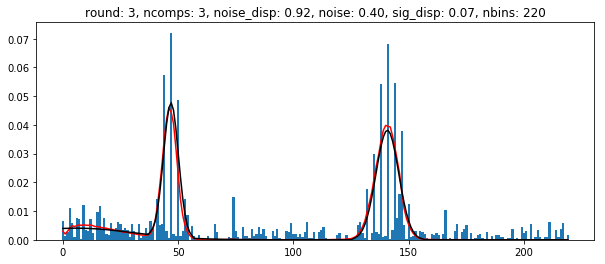

sim 2310/500000, loss: 0.2654, losses_av: 0.1566, tv: 0.00424, tv_trend: 0.00643,  shrink: 0.0289, ll: 0.0101, KL: 0.0905, nbins: 288
sim 2320/500000, loss: 0.0640, losses_av: 0.1564, tv: 0.00424, tv_trend: 0.00644,  shrink: 0.0289, ll: 0.0101, KL: 0.0904, nbins: 151
sim 2330/500000, loss: 0.0743, losses_av: 0.1567, tv: 0.00425, tv_trend: 0.00646,  shrink: 0.0289, ll: 0.0101, KL: 0.0905, nbins: 215
sim 2340/500000, loss: 0.1590, losses_av: 0.1567, tv: 0.00425, tv_trend: 0.00646,  shrink: 0.0289, ll: 0.0101, KL: 0.0905, nbins: 570
sim 2350/500000, loss: 0.2355, losses_av: 0.1571, tv: 0.00428, tv_trend: 0.00651,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 385
sim 2360/500000, loss: 0.1105, losses_av: 0.1575, tv: 0.00428, tv_trend: 0.00652,  shrink: 0.0289, ll: 0.0102, KL: 0.0908, nbins: 595
sim 2370/500000, loss: 0.2215, losses_av: 0.1573, tv: 0.00428, tv_trend: 0.00653,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 91
sim 2380/500000, loss: 0.0709, losses_av: 0.1568, tv: 0.00427, 

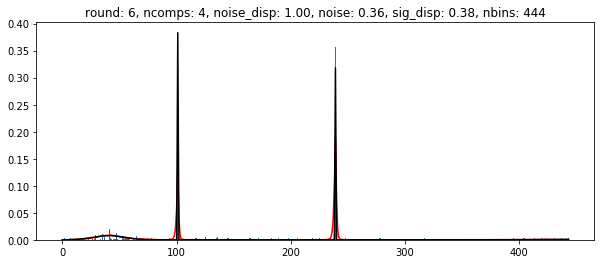

sim 2410/500000, loss: 0.2204, losses_av: 0.1572, tv: 0.00431, tv_trend: 0.00659,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 327
sim 2420/500000, loss: 0.2036, losses_av: 0.1574, tv: 0.00432, tv_trend: 0.00660,  shrink: 0.0289, ll: 0.0102, KL: 0.0907, nbins: 440
sim 2430/500000, loss: 0.1110, losses_av: 0.1576, tv: 0.00432, tv_trend: 0.00659,  shrink: 0.0289, ll: 0.0102, KL: 0.0908, nbins: 26
sim 2440/500000, loss: 0.0850, losses_av: 0.1572, tv: 0.00431, tv_trend: 0.00658,  shrink: 0.0289, ll: 0.0102, KL: 0.0907, nbins: 550
sim 2450/500000, loss: 0.1379, losses_av: 0.1568, tv: 0.00430, tv_trend: 0.00655,  shrink: 0.0289, ll: 0.0101, KL: 0.0905, nbins: 497
sim 2460/500000, loss: 0.0653, losses_av: 0.1568, tv: 0.00429, tv_trend: 0.00653,  shrink: 0.0289, ll: 0.0101, KL: 0.0905, nbins: 419
sim 2470/500000, loss: 0.1970, losses_av: 0.1567, tv: 0.00428, tv_trend: 0.00652,  shrink: 0.0288, ll: 0.0101, KL: 0.0905, nbins: 558
sim 2480/500000, loss: 0.1705, losses_av: 0.1568, tv: 0.00428, 

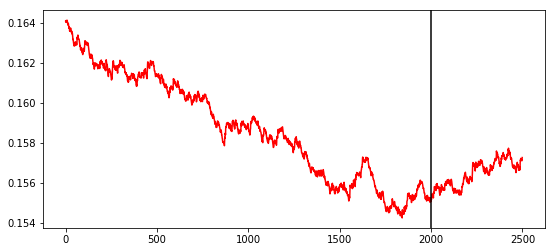

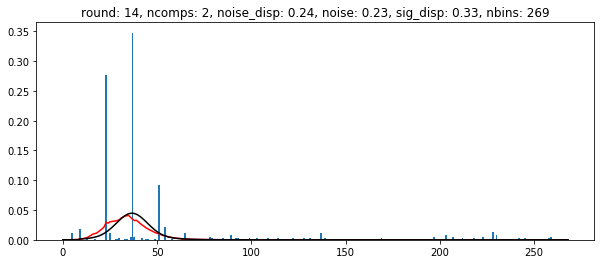

sim 2510/500000, loss: 0.2411, losses_av: 0.1571, tv: 0.00431, tv_trend: 0.00655,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 121
sim 2520/500000, loss: 0.0759, losses_av: 0.1570, tv: 0.00430, tv_trend: 0.00654,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 218
sim 2530/500000, loss: 0.0858, losses_av: 0.1572, tv: 0.00431, tv_trend: 0.00656,  shrink: 0.0289, ll: 0.0102, KL: 0.0908, nbins: 549
sim 2540/500000, loss: 0.1755, losses_av: 0.1571, tv: 0.00431, tv_trend: 0.00654,  shrink: 0.0289, ll: 0.0101, KL: 0.0908, nbins: 555
sim 2550/500000, loss: 0.2102, losses_av: 0.1572, tv: 0.00431, tv_trend: 0.00656,  shrink: 0.0288, ll: 0.0102, KL: 0.0907, nbins: 99
sim 2560/500000, loss: 0.2252, losses_av: 0.1569, tv: 0.00432, tv_trend: 0.00656,  shrink: 0.0289, ll: 0.0101, KL: 0.0906, nbins: 482
sim 2570/500000, loss: 0.1031, losses_av: 0.1570, tv: 0.00431, tv_trend: 0.00654,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 284
sim 2580/500000, loss: 0.2034, losses_av: 0.1571, tv: 0.00430, 

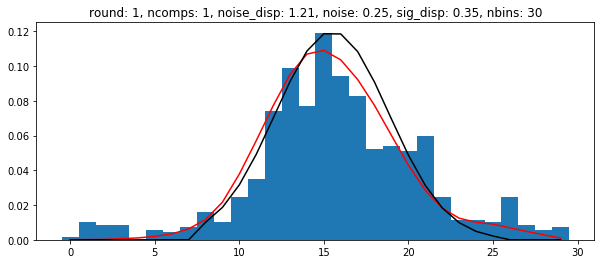

sim 2610/500000, loss: 0.0894, losses_av: 0.1570, tv: 0.00429, tv_trend: 0.00648,  shrink: 0.0289, ll: 0.0102, KL: 0.0905, nbins: 268
sim 2620/500000, loss: 0.2021, losses_av: 0.1572, tv: 0.00429, tv_trend: 0.00648,  shrink: 0.0289, ll: 0.0102, KL: 0.0906, nbins: 239
sim 2630/500000, loss: 0.0860, losses_av: 0.1565, tv: 0.00427, tv_trend: 0.00645,  shrink: 0.0289, ll: 0.0101, KL: 0.0903, nbins: 52
sim 2640/500000, loss: 0.1189, losses_av: 0.1566, tv: 0.00428, tv_trend: 0.00647,  shrink: 0.0289, ll: 0.0101, KL: 0.0903, nbins: 23
sim 2650/500000, loss: 0.0880, losses_av: 0.1572, tv: 0.00431, tv_trend: 0.00651,  shrink: 0.0290, ll: 0.0102, KL: 0.0904, nbins: 188
sim 2660/500000, loss: 0.0809, losses_av: 0.1569, tv: 0.00430, tv_trend: 0.00648,  shrink: 0.0289, ll: 0.0102, KL: 0.0903, nbins: 593
sim 2670/500000, loss: 0.1552, losses_av: 0.1571, tv: 0.00431, tv_trend: 0.00651,  shrink: 0.0290, ll: 0.0102, KL: 0.0903, nbins: 276
sim 2680/500000, loss: 0.1681, losses_av: 0.1574, tv: 0.00431, t

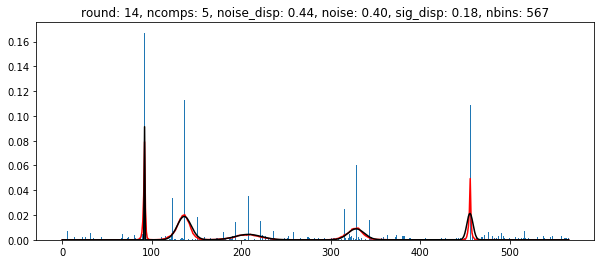

sim 2710/500000, loss: 0.2900, losses_av: 0.1574, tv: 0.00432, tv_trend: 0.00651,  shrink: 0.0290, ll: 0.0103, KL: 0.0903, nbins: 14
sim 2720/500000, loss: 0.1029, losses_av: 0.1570, tv: 0.00431, tv_trend: 0.00649,  shrink: 0.0290, ll: 0.0102, KL: 0.0902, nbins: 235
sim 2730/500000, loss: 0.0538, losses_av: 0.1566, tv: 0.00429, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0102, KL: 0.0900, nbins: 66
sim 2740/500000, loss: 0.0808, losses_av: 0.1563, tv: 0.00428, tv_trend: 0.00644,  shrink: 0.0290, ll: 0.0101, KL: 0.0899, nbins: 362
sim 2750/500000, loss: 0.2222, losses_av: 0.1565, tv: 0.00427, tv_trend: 0.00642,  shrink: 0.0289, ll: 0.0102, KL: 0.0900, nbins: 485
sim 2760/500000, loss: 0.0505, losses_av: 0.1559, tv: 0.00425, tv_trend: 0.00639,  shrink: 0.0289, ll: 0.0101, KL: 0.0898, nbins: 598
sim 2770/500000, loss: 0.0504, losses_av: 0.1560, tv: 0.00426, tv_trend: 0.00639,  shrink: 0.0289, ll: 0.0101, KL: 0.0898, nbins: 292
sim 2780/500000, loss: 0.2131, losses_av: 0.1561, tv: 0.00426, t

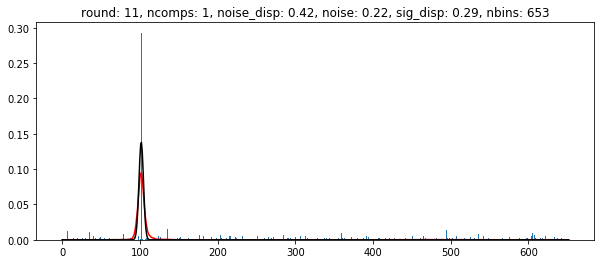

sim 2810/500000, loss: 0.0627, losses_av: 0.1558, tv: 0.00423, tv_trend: 0.00634,  shrink: 0.0288, ll: 0.0101, KL: 0.0898, nbins: 283
sim 2820/500000, loss: 0.1533, losses_av: 0.1556, tv: 0.00423, tv_trend: 0.00633,  shrink: 0.0288, ll: 0.0101, KL: 0.0897, nbins: 111
sim 2830/500000, loss: 0.0955, losses_av: 0.1554, tv: 0.00422, tv_trend: 0.00632,  shrink: 0.0289, ll: 0.0101, KL: 0.0896, nbins: 440
sim 2840/500000, loss: 0.1093, losses_av: 0.1553, tv: 0.00422, tv_trend: 0.00631,  shrink: 0.0289, ll: 0.0101, KL: 0.0896, nbins: 42
sim 2850/500000, loss: 0.1590, losses_av: 0.1555, tv: 0.00423, tv_trend: 0.00632,  shrink: 0.0289, ll: 0.0101, KL: 0.0897, nbins: 158
sim 2860/500000, loss: 0.0960, losses_av: 0.1552, tv: 0.00421, tv_trend: 0.00630,  shrink: 0.0288, ll: 0.0100, KL: 0.0896, nbins: 322
sim 2870/500000, loss: 0.1140, losses_av: 0.1548, tv: 0.00420, tv_trend: 0.00629,  shrink: 0.0288, ll: 0.0100, KL: 0.0894, nbins: 515
sim 2880/500000, loss: 0.1932, losses_av: 0.1552, tv: 0.00421, 

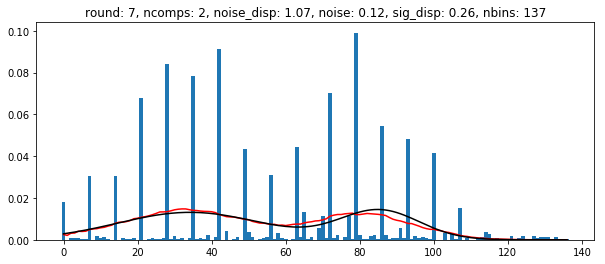

sim 2910/500000, loss: 0.1119, losses_av: 0.1552, tv: 0.00420, tv_trend: 0.00628,  shrink: 0.0287, ll: 0.0101, KL: 0.0897, nbins: 447
sim 2920/500000, loss: 0.0765, losses_av: 0.1549, tv: 0.00419, tv_trend: 0.00626,  shrink: 0.0287, ll: 0.0100, KL: 0.0895, nbins: 348
sim 2930/500000, loss: 0.0883, losses_av: 0.1549, tv: 0.00418, tv_trend: 0.00624,  shrink: 0.0287, ll: 0.0100, KL: 0.0895, nbins: 505
sim 2940/500000, loss: 0.0428, losses_av: 0.1548, tv: 0.00418, tv_trend: 0.00624,  shrink: 0.0287, ll: 0.0100, KL: 0.0895, nbins: 362
sim 2950/500000, loss: 0.1743, losses_av: 0.1544, tv: 0.00417, tv_trend: 0.00622,  shrink: 0.0287, ll: 0.0100, KL: 0.0893, nbins: 109
sim 2960/500000, loss: 0.0861, losses_av: 0.1540, tv: 0.00416, tv_trend: 0.00620,  shrink: 0.0287, ll: 0.0099, KL: 0.0892, nbins: 186
sim 2970/500000, loss: 0.2463, losses_av: 0.1538, tv: 0.00416, tv_trend: 0.00621,  shrink: 0.0287, ll: 0.0099, KL: 0.0892, nbins: 290
sim 2980/500000, loss: 0.3198, losses_av: 0.1538, tv: 0.00417,

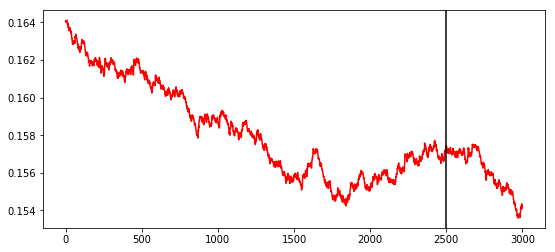

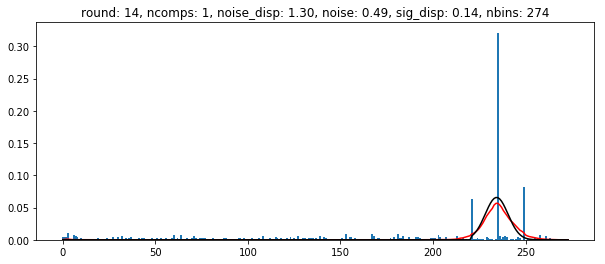

sim 3010/500000, loss: 0.0597, losses_av: 0.1544, tv: 0.00420, tv_trend: 0.00626,  shrink: 0.0288, ll: 0.0100, KL: 0.0892, nbins: 369
sim 3020/500000, loss: 0.0935, losses_av: 0.1547, tv: 0.00421, tv_trend: 0.00629,  shrink: 0.0289, ll: 0.0100, KL: 0.0893, nbins: 420
sim 3030/500000, loss: 0.0819, losses_av: 0.1545, tv: 0.00421, tv_trend: 0.00629,  shrink: 0.0289, ll: 0.0100, KL: 0.0893, nbins: 580
sim 3040/500000, loss: 0.0677, losses_av: 0.1546, tv: 0.00421, tv_trend: 0.00629,  shrink: 0.0289, ll: 0.0100, KL: 0.0892, nbins: 295
sim 3050/500000, loss: 0.0650, losses_av: 0.1546, tv: 0.00422, tv_trend: 0.00631,  shrink: 0.0289, ll: 0.0100, KL: 0.0892, nbins: 342
sim 3060/500000, loss: 0.1131, losses_av: 0.1542, tv: 0.00422, tv_trend: 0.00631,  shrink: 0.0289, ll: 0.0100, KL: 0.0891, nbins: 455
sim 3070/500000, loss: 0.0922, losses_av: 0.1547, tv: 0.00425, tv_trend: 0.00638,  shrink: 0.0289, ll: 0.0100, KL: 0.0893, nbins: 522
sim 3080/500000, loss: 0.1216, losses_av: 0.1547, tv: 0.00424,

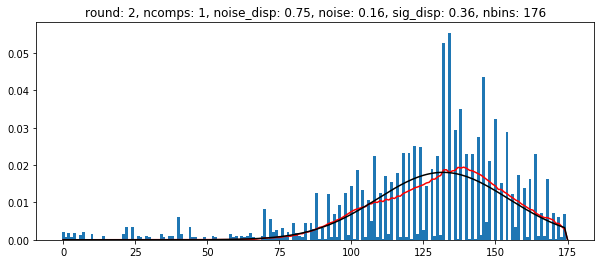

sim 3110/500000, loss: 0.1369, losses_av: 0.1548, tv: 0.00426, tv_trend: 0.00640,  shrink: 0.0289, ll: 0.0100, KL: 0.0891, nbins: 430
sim 3120/500000, loss: 0.2439, losses_av: 0.1544, tv: 0.00426, tv_trend: 0.00640,  shrink: 0.0289, ll: 0.0100, KL: 0.0889, nbins: 409
sim 3130/500000, loss: 0.2260, losses_av: 0.1543, tv: 0.00427, tv_trend: 0.00643,  shrink: 0.0289, ll: 0.0100, KL: 0.0889, nbins: 229
sim 3140/500000, loss: 0.0759, losses_av: 0.1543, tv: 0.00428, tv_trend: 0.00645,  shrink: 0.0288, ll: 0.0100, KL: 0.0890, nbins: 374
sim 3150/500000, loss: 0.0665, losses_av: 0.1540, tv: 0.00427, tv_trend: 0.00644,  shrink: 0.0288, ll: 0.0099, KL: 0.0889, nbins: 168
sim 3160/500000, loss: 0.0891, losses_av: 0.1538, tv: 0.00426, tv_trend: 0.00642,  shrink: 0.0288, ll: 0.0099, KL: 0.0889, nbins: 588
sim 3170/500000, loss: 0.1996, losses_av: 0.1538, tv: 0.00425, tv_trend: 0.00641,  shrink: 0.0288, ll: 0.0099, KL: 0.0888, nbins: 164
sim 3180/500000, loss: 0.0525, losses_av: 0.1539, tv: 0.00425,

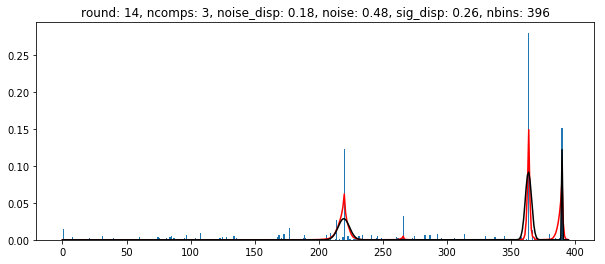

sim 3210/500000, loss: 0.0754, losses_av: 0.1533, tv: 0.00422, tv_trend: 0.00637,  shrink: 0.0287, ll: 0.0099, KL: 0.0887, nbins: 488
sim 3220/500000, loss: 0.0300, losses_av: 0.1531, tv: 0.00422, tv_trend: 0.00637,  shrink: 0.0287, ll: 0.0099, KL: 0.0885, nbins: 388
sim 3230/500000, loss: 0.0749, losses_av: 0.1527, tv: 0.00420, tv_trend: 0.00635,  shrink: 0.0287, ll: 0.0098, KL: 0.0883, nbins: 157
sim 3240/500000, loss: 0.0669, losses_av: 0.1523, tv: 0.00419, tv_trend: 0.00633,  shrink: 0.0286, ll: 0.0098, KL: 0.0882, nbins: 407
sim 3250/500000, loss: 0.0879, losses_av: 0.1524, tv: 0.00418, tv_trend: 0.00630,  shrink: 0.0286, ll: 0.0098, KL: 0.0882, nbins: 411
sim 3260/500000, loss: 0.3449, losses_av: 0.1527, tv: 0.00419, tv_trend: 0.00631,  shrink: 0.0286, ll: 0.0098, KL: 0.0883, nbins: 461
sim 3270/500000, loss: 0.1032, losses_av: 0.1527, tv: 0.00419, tv_trend: 0.00631,  shrink: 0.0286, ll: 0.0098, KL: 0.0883, nbins: 293
sim 3280/500000, loss: 0.0839, losses_av: 0.1522, tv: 0.00418,

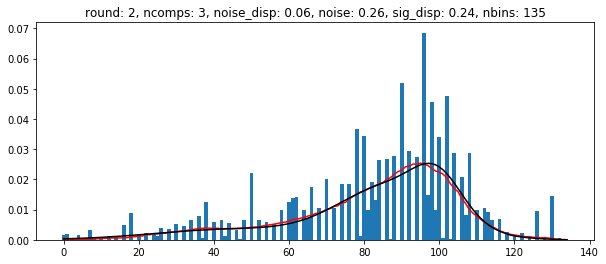

sim 3310/500000, loss: 0.1829, losses_av: 0.1529, tv: 0.00420, tv_trend: 0.00631,  shrink: 0.0288, ll: 0.0099, KL: 0.0883, nbins: 181
sim 3320/500000, loss: 0.1630, losses_av: 0.1531, tv: 0.00421, tv_trend: 0.00633,  shrink: 0.0289, ll: 0.0099, KL: 0.0884, nbins: 112
sim 3330/500000, loss: 0.1706, losses_av: 0.1534, tv: 0.00423, tv_trend: 0.00636,  shrink: 0.0289, ll: 0.0099, KL: 0.0885, nbins: 153
sim 3340/500000, loss: 0.1828, losses_av: 0.1535, tv: 0.00424, tv_trend: 0.00640,  shrink: 0.0289, ll: 0.0099, KL: 0.0885, nbins: 329
sim 3350/500000, loss: 0.3412, losses_av: 0.1537, tv: 0.00424, tv_trend: 0.00639,  shrink: 0.0289, ll: 0.0100, KL: 0.0886, nbins: 508
sim 3360/500000, loss: 0.2103, losses_av: 0.1535, tv: 0.00424, tv_trend: 0.00638,  shrink: 0.0289, ll: 0.0099, KL: 0.0886, nbins: 110
sim 3370/500000, loss: 0.1370, losses_av: 0.1539, tv: 0.00426, tv_trend: 0.00642,  shrink: 0.0290, ll: 0.0100, KL: 0.0887, nbins: 572
sim 3380/500000, loss: 0.0702, losses_av: 0.1536, tv: 0.00425,

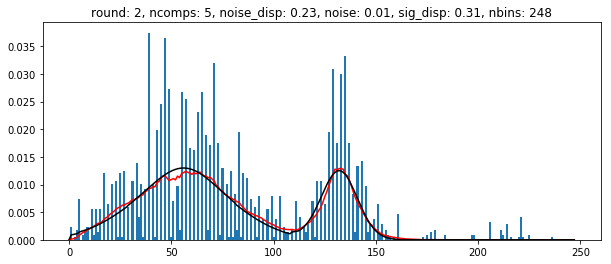

sim 3410/500000, loss: 0.1235, losses_av: 0.1530, tv: 0.00423, tv_trend: 0.00637,  shrink: 0.0290, ll: 0.0099, KL: 0.0884, nbins: 112
sim 3420/500000, loss: 0.2671, losses_av: 0.1529, tv: 0.00422, tv_trend: 0.00636,  shrink: 0.0289, ll: 0.0099, KL: 0.0883, nbins: 391
sim 3430/500000, loss: 0.2788, losses_av: 0.1528, tv: 0.00422, tv_trend: 0.00636,  shrink: 0.0289, ll: 0.0098, KL: 0.0883, nbins: 136
sim 3440/500000, loss: 0.1530, losses_av: 0.1531, tv: 0.00423, tv_trend: 0.00639,  shrink: 0.0290, ll: 0.0099, KL: 0.0883, nbins: 244
sim 3450/500000, loss: 0.0564, losses_av: 0.1529, tv: 0.00424, tv_trend: 0.00639,  shrink: 0.0291, ll: 0.0099, KL: 0.0882, nbins: 351
sim 3460/500000, loss: 0.1337, losses_av: 0.1530, tv: 0.00427, tv_trend: 0.00644,  shrink: 0.0291, ll: 0.0099, KL: 0.0882, nbins: 321
sim 3470/500000, loss: 0.0468, losses_av: 0.1533, tv: 0.00427, tv_trend: 0.00645,  shrink: 0.0291, ll: 0.0099, KL: 0.0883, nbins: 243
sim 3480/500000, loss: 0.3474, losses_av: 0.1537, tv: 0.00428,

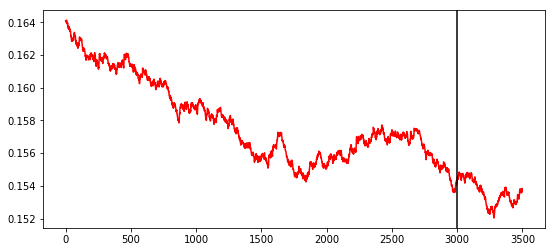

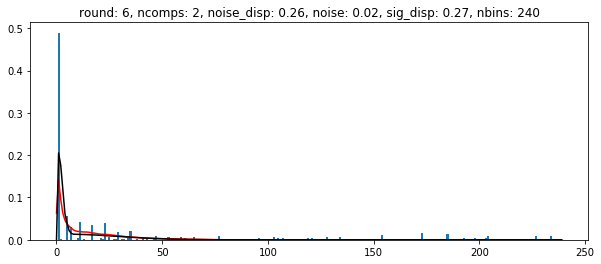

sim 3510/500000, loss: 0.1652, losses_av: 0.1535, tv: 0.00427, tv_trend: 0.00643,  shrink: 0.0291, ll: 0.0099, KL: 0.0884, nbins: 524
sim 3520/500000, loss: 0.0866, losses_av: 0.1533, tv: 0.00427, tv_trend: 0.00643,  shrink: 0.0291, ll: 0.0099, KL: 0.0883, nbins: 400
sim 3530/500000, loss: 0.1868, losses_av: 0.1534, tv: 0.00426, tv_trend: 0.00641,  shrink: 0.0290, ll: 0.0099, KL: 0.0884, nbins: 44
sim 3540/500000, loss: 0.1654, losses_av: 0.1534, tv: 0.00425, tv_trend: 0.00640,  shrink: 0.0290, ll: 0.0099, KL: 0.0884, nbins: 509
sim 3550/500000, loss: 0.1258, losses_av: 0.1532, tv: 0.00424, tv_trend: 0.00639,  shrink: 0.0290, ll: 0.0099, KL: 0.0883, nbins: 592
sim 3560/500000, loss: 0.2429, losses_av: 0.1535, tv: 0.00425, tv_trend: 0.00641,  shrink: 0.0290, ll: 0.0100, KL: 0.0883, nbins: 255
sim 3570/500000, loss: 0.0676, losses_av: 0.1534, tv: 0.00425, tv_trend: 0.00640,  shrink: 0.0290, ll: 0.0100, KL: 0.0883, nbins: 411
sim 3580/500000, loss: 0.0680, losses_av: 0.1539, tv: 0.00427, 

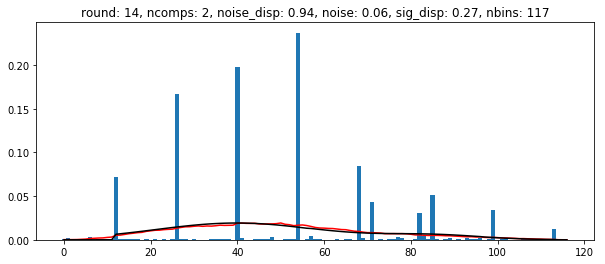

sim 3610/500000, loss: 0.1480, losses_av: 0.1534, tv: 0.00425, tv_trend: 0.00641,  shrink: 0.0289, ll: 0.0099, KL: 0.0883, nbins: 129
sim 3620/500000, loss: 0.0847, losses_av: 0.1532, tv: 0.00424, tv_trend: 0.00640,  shrink: 0.0289, ll: 0.0099, KL: 0.0882, nbins: 430
sim 3630/500000, loss: 0.1073, losses_av: 0.1531, tv: 0.00424, tv_trend: 0.00639,  shrink: 0.0290, ll: 0.0099, KL: 0.0882, nbins: 227
sim 3640/500000, loss: 0.1129, losses_av: 0.1530, tv: 0.00423, tv_trend: 0.00638,  shrink: 0.0289, ll: 0.0099, KL: 0.0882, nbins: 249
sim 3650/500000, loss: 0.0822, losses_av: 0.1527, tv: 0.00422, tv_trend: 0.00636,  shrink: 0.0289, ll: 0.0099, KL: 0.0880, nbins: 580
sim 3660/500000, loss: 0.1513, losses_av: 0.1526, tv: 0.00422, tv_trend: 0.00636,  shrink: 0.0289, ll: 0.0099, KL: 0.0880, nbins: 323
sim 3670/500000, loss: 0.0486, losses_av: 0.1528, tv: 0.00422, tv_trend: 0.00636,  shrink: 0.0289, ll: 0.0099, KL: 0.0881, nbins: 600
sim 3680/500000, loss: 0.1216, losses_av: 0.1530, tv: 0.00422,

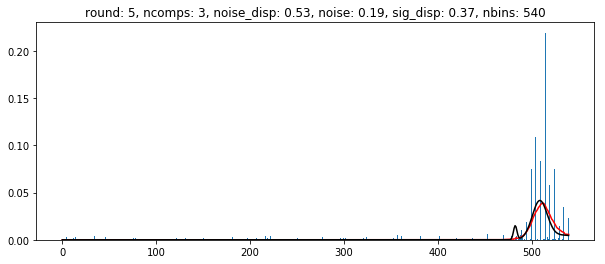

sim 3710/500000, loss: 0.1817, losses_av: 0.1525, tv: 0.00420, tv_trend: 0.00633,  shrink: 0.0289, ll: 0.0099, KL: 0.0879, nbins: 428
sim 3720/500000, loss: 0.0801, losses_av: 0.1522, tv: 0.00419, tv_trend: 0.00630,  shrink: 0.0288, ll: 0.0099, KL: 0.0878, nbins: 588
sim 3730/500000, loss: 0.3380, losses_av: 0.1527, tv: 0.00420, tv_trend: 0.00631,  shrink: 0.0290, ll: 0.0099, KL: 0.0880, nbins: 232
sim 3740/500000, loss: 0.0841, losses_av: 0.1526, tv: 0.00420, tv_trend: 0.00630,  shrink: 0.0290, ll: 0.0099, KL: 0.0880, nbins: 482
sim 3750/500000, loss: 0.1789, losses_av: 0.1532, tv: 0.00420, tv_trend: 0.00631,  shrink: 0.0290, ll: 0.0100, KL: 0.0882, nbins: 401
sim 3760/500000, loss: 0.1929, losses_av: 0.1531, tv: 0.00420, tv_trend: 0.00631,  shrink: 0.0290, ll: 0.0100, KL: 0.0882, nbins: 159
sim 3770/500000, loss: 0.3939, losses_av: 0.1533, tv: 0.00421, tv_trend: 0.00634,  shrink: 0.0290, ll: 0.0100, KL: 0.0883, nbins: 281
sim 3780/500000, loss: 0.0763, losses_av: 0.1534, tv: 0.00421,

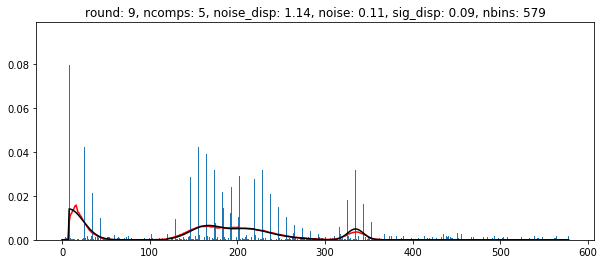

sim 3810/500000, loss: 0.1531, losses_av: 0.1538, tv: 0.00420, tv_trend: 0.00631,  shrink: 0.0291, ll: 0.0100, KL: 0.0886, nbins: 576
sim 3820/500000, loss: 0.1578, losses_av: 0.1544, tv: 0.00421, tv_trend: 0.00632,  shrink: 0.0291, ll: 0.0101, KL: 0.0888, nbins: 376
sim 3830/500000, loss: 0.1197, losses_av: 0.1544, tv: 0.00419, tv_trend: 0.00629,  shrink: 0.0291, ll: 0.0101, KL: 0.0889, nbins: 561
sim 3840/500000, loss: 0.3004, losses_av: 0.1542, tv: 0.00418, tv_trend: 0.00627,  shrink: 0.0290, ll: 0.0101, KL: 0.0889, nbins: 158
sim 3850/500000, loss: 0.0697, losses_av: 0.1539, tv: 0.00417, tv_trend: 0.00625,  shrink: 0.0290, ll: 0.0100, KL: 0.0887, nbins: 415
sim 3860/500000, loss: 0.1051, losses_av: 0.1537, tv: 0.00417, tv_trend: 0.00624,  shrink: 0.0290, ll: 0.0100, KL: 0.0887, nbins: 268
sim 3870/500000, loss: 0.1221, losses_av: 0.1536, tv: 0.00416, tv_trend: 0.00624,  shrink: 0.0290, ll: 0.0100, KL: 0.0886, nbins: 492
sim 3880/500000, loss: 0.1822, losses_av: 0.1534, tv: 0.00415,

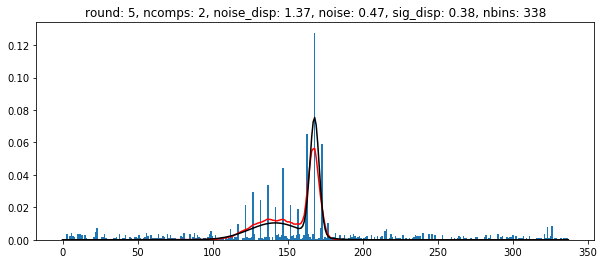

sim 3910/500000, loss: 0.2024, losses_av: 0.1537, tv: 0.00417, tv_trend: 0.00624,  shrink: 0.0290, ll: 0.0100, KL: 0.0886, nbins: 61
sim 3920/500000, loss: 0.1090, losses_av: 0.1534, tv: 0.00416, tv_trend: 0.00622,  shrink: 0.0290, ll: 0.0100, KL: 0.0886, nbins: 317
sim 3930/500000, loss: 0.4661, losses_av: 0.1538, tv: 0.00417, tv_trend: 0.00623,  shrink: 0.0290, ll: 0.0100, KL: 0.0887, nbins: 558
sim 3940/500000, loss: 0.0839, losses_av: 0.1543, tv: 0.00419, tv_trend: 0.00626,  shrink: 0.0290, ll: 0.0101, KL: 0.0888, nbins: 63
sim 3950/500000, loss: 0.1031, losses_av: 0.1543, tv: 0.00420, tv_trend: 0.00627,  shrink: 0.0290, ll: 0.0101, KL: 0.0887, nbins: 417
sim 3960/500000, loss: 0.0513, losses_av: 0.1544, tv: 0.00420, tv_trend: 0.00629,  shrink: 0.0290, ll: 0.0101, KL: 0.0888, nbins: 541
sim 3970/500000, loss: 0.1771, losses_av: 0.1547, tv: 0.00422, tv_trend: 0.00632,  shrink: 0.0289, ll: 0.0101, KL: 0.0888, nbins: 398
sim 3980/500000, loss: 0.2486, losses_av: 0.1549, tv: 0.00424, t

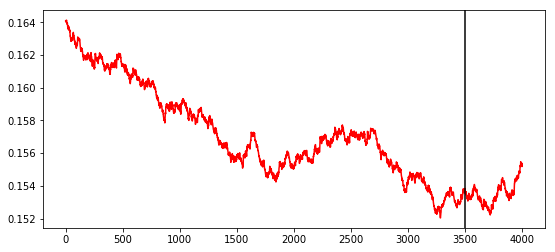

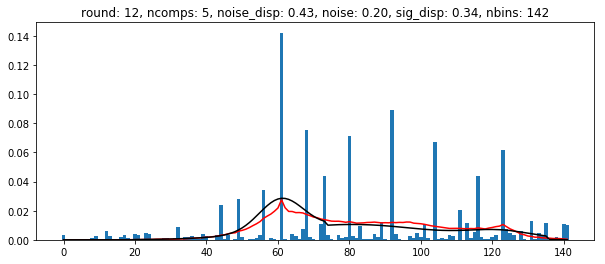

sim 4010/500000, loss: 0.1176, losses_av: 0.1552, tv: 0.00426, tv_trend: 0.00642,  shrink: 0.0289, ll: 0.0102, KL: 0.0889, nbins: 100
sim 4020/500000, loss: 0.1073, losses_av: 0.1551, tv: 0.00426, tv_trend: 0.00642,  shrink: 0.0289, ll: 0.0102, KL: 0.0889, nbins: 342
sim 4030/500000, loss: 0.1431, losses_av: 0.1551, tv: 0.00427, tv_trend: 0.00645,  shrink: 0.0289, ll: 0.0102, KL: 0.0889, nbins: 594
sim 4040/500000, loss: 0.0600, losses_av: 0.1550, tv: 0.00428, tv_trend: 0.00646,  shrink: 0.0289, ll: 0.0101, KL: 0.0888, nbins: 436
sim 4050/500000, loss: 0.1590, losses_av: 0.1547, tv: 0.00427, tv_trend: 0.00644,  shrink: 0.0288, ll: 0.0101, KL: 0.0887, nbins: 557
sim 4060/500000, loss: 0.2527, losses_av: 0.1545, tv: 0.00426, tv_trend: 0.00643,  shrink: 0.0288, ll: 0.0101, KL: 0.0886, nbins: 471
sim 4070/500000, loss: 0.1726, losses_av: 0.1546, tv: 0.00426, tv_trend: 0.00643,  shrink: 0.0288, ll: 0.0101, KL: 0.0887, nbins: 44
sim 4080/500000, loss: 0.0762, losses_av: 0.1545, tv: 0.00426, 

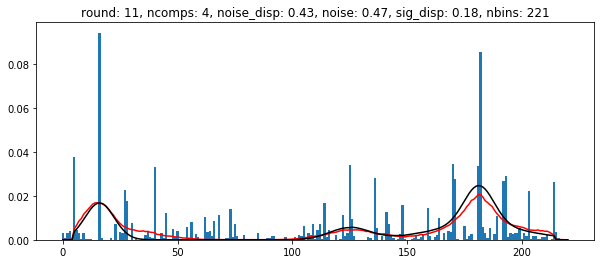

sim 4110/500000, loss: 0.1858, losses_av: 0.1553, tv: 0.00425, tv_trend: 0.00640,  shrink: 0.0288, ll: 0.0101, KL: 0.0890, nbins: 341
sim 4120/500000, loss: 0.0798, losses_av: 0.1548, tv: 0.00424, tv_trend: 0.00639,  shrink: 0.0288, ll: 0.0101, KL: 0.0888, nbins: 153
sim 4130/500000, loss: 0.1041, losses_av: 0.1548, tv: 0.00423, tv_trend: 0.00638,  shrink: 0.0287, ll: 0.0101, KL: 0.0888, nbins: 255
sim 4140/500000, loss: 0.1290, losses_av: 0.1546, tv: 0.00422, tv_trend: 0.00636,  shrink: 0.0287, ll: 0.0101, KL: 0.0888, nbins: 101
sim 4150/500000, loss: 0.1020, losses_av: 0.1548, tv: 0.00423, tv_trend: 0.00637,  shrink: 0.0288, ll: 0.0101, KL: 0.0888, nbins: 186
sim 4160/500000, loss: 0.1202, losses_av: 0.1549, tv: 0.00424, tv_trend: 0.00638,  shrink: 0.0287, ll: 0.0101, KL: 0.0889, nbins: 340
sim 4170/500000, loss: 0.0909, losses_av: 0.1556, tv: 0.00427, tv_trend: 0.00645,  shrink: 0.0288, ll: 0.0102, KL: 0.0890, nbins: 567
sim 4180/500000, loss: 0.2361, losses_av: 0.1555, tv: 0.00427,

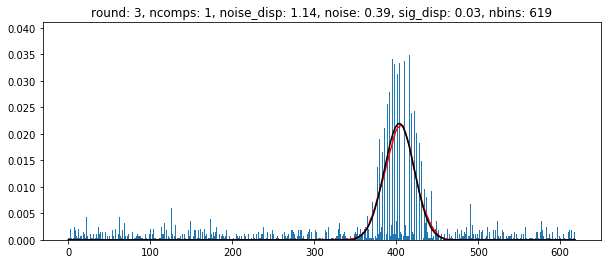

sim 4210/500000, loss: 0.1744, losses_av: 0.1554, tv: 0.00428, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0102, KL: 0.0889, nbins: 475
sim 4220/500000, loss: 0.0576, losses_av: 0.1551, tv: 0.00427, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0101, KL: 0.0887, nbins: 580
sim 4230/500000, loss: 0.0673, losses_av: 0.1551, tv: 0.00428, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0101, KL: 0.0887, nbins: 140
sim 4240/500000, loss: 0.0509, losses_av: 0.1546, tv: 0.00427, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0101, KL: 0.0885, nbins: 512
sim 4250/500000, loss: 0.1643, losses_av: 0.1546, tv: 0.00428, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0101, KL: 0.0885, nbins: 13
sim 4260/500000, loss: 0.1426, losses_av: 0.1544, tv: 0.00427, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0101, KL: 0.0884, nbins: 18
sim 4270/500000, loss: 0.0673, losses_av: 0.1540, tv: 0.00427, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0100, KL: 0.0883, nbins: 509
sim 4280/500000, loss: 0.1797, losses_av: 0.1540, tv: 0.00428, t

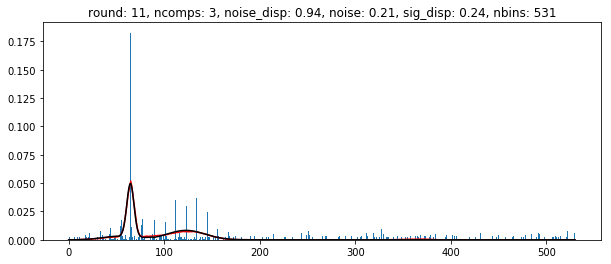

sim 4310/500000, loss: 0.2323, losses_av: 0.1540, tv: 0.00428, tv_trend: 0.00646,  shrink: 0.0288, ll: 0.0100, KL: 0.0881, nbins: 114
sim 4320/500000, loss: 0.0553, losses_av: 0.1536, tv: 0.00426, tv_trend: 0.00642,  shrink: 0.0287, ll: 0.0100, KL: 0.0879, nbins: 300
sim 4330/500000, loss: 0.2564, losses_av: 0.1536, tv: 0.00427, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0100, KL: 0.0878, nbins: 217
sim 4340/500000, loss: 0.2823, losses_av: 0.1539, tv: 0.00428, tv_trend: 0.00647,  shrink: 0.0287, ll: 0.0101, KL: 0.0879, nbins: 497
sim 4350/500000, loss: 0.2216, losses_av: 0.1540, tv: 0.00429, tv_trend: 0.00648,  shrink: 0.0287, ll: 0.0101, KL: 0.0878, nbins: 385
sim 4360/500000, loss: 0.0685, losses_av: 0.1536, tv: 0.00428, tv_trend: 0.00647,  shrink: 0.0287, ll: 0.0100, KL: 0.0877, nbins: 103
sim 4370/500000, loss: 0.2007, losses_av: 0.1533, tv: 0.00427, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0100, KL: 0.0877, nbins: 288
sim 4380/500000, loss: 0.0613, losses_av: 0.1536, tv: 0.00429,

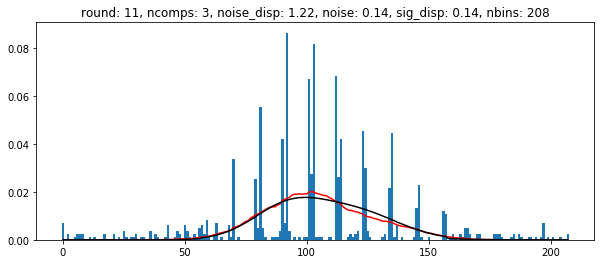

sim 4410/500000, loss: 0.1422, losses_av: 0.1534, tv: 0.00424, tv_trend: 0.00642,  shrink: 0.0286, ll: 0.0100, KL: 0.0879, nbins: 75
sim 4420/500000, loss: 0.1049, losses_av: 0.1533, tv: 0.00423, tv_trend: 0.00640,  shrink: 0.0285, ll: 0.0100, KL: 0.0879, nbins: 501
sim 4430/500000, loss: 0.1146, losses_av: 0.1541, tv: 0.00424, tv_trend: 0.00641,  shrink: 0.0287, ll: 0.0101, KL: 0.0882, nbins: 480
sim 4440/500000, loss: 0.0791, losses_av: 0.1541, tv: 0.00424, tv_trend: 0.00642,  shrink: 0.0286, ll: 0.0100, KL: 0.0884, nbins: 262
sim 4450/500000, loss: 0.1754, losses_av: 0.1541, tv: 0.00424, tv_trend: 0.00640,  shrink: 0.0286, ll: 0.0100, KL: 0.0883, nbins: 472
sim 4460/500000, loss: 0.0578, losses_av: 0.1539, tv: 0.00422, tv_trend: 0.00637,  shrink: 0.0286, ll: 0.0100, KL: 0.0882, nbins: 422
sim 4470/500000, loss: 0.1051, losses_av: 0.1538, tv: 0.00420, tv_trend: 0.00634,  shrink: 0.0285, ll: 0.0100, KL: 0.0882, nbins: 138
sim 4480/500000, loss: 0.1674, losses_av: 0.1540, tv: 0.00420, 

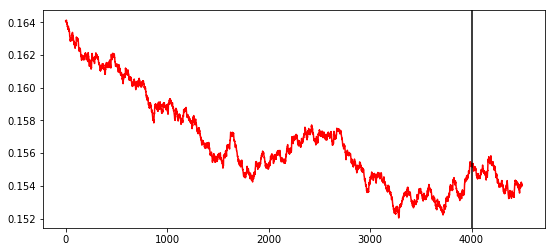

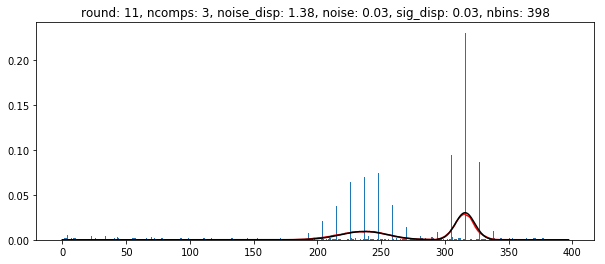

sim 4510/500000, loss: 0.1700, losses_av: 0.1546, tv: 0.00424, tv_trend: 0.00642,  shrink: 0.0287, ll: 0.0101, KL: 0.0884, nbins: 168
sim 4520/500000, loss: 0.2771, losses_av: 0.1551, tv: 0.00426, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0102, KL: 0.0886, nbins: 52
sim 4530/500000, loss: 0.1331, losses_av: 0.1550, tv: 0.00426, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0102, KL: 0.0886, nbins: 293
sim 4540/500000, loss: 0.0658, losses_av: 0.1547, tv: 0.00426, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0101, KL: 0.0884, nbins: 544
sim 4550/500000, loss: 0.0617, losses_av: 0.1549, tv: 0.00428, tv_trend: 0.00648,  shrink: 0.0287, ll: 0.0101, KL: 0.0885, nbins: 462
sim 4560/500000, loss: 0.2497, losses_av: 0.1549, tv: 0.00428, tv_trend: 0.00648,  shrink: 0.0287, ll: 0.0101, KL: 0.0885, nbins: 86
sim 4570/500000, loss: 0.1867, losses_av: 0.1547, tv: 0.00428, tv_trend: 0.00648,  shrink: 0.0287, ll: 0.0101, KL: 0.0884, nbins: 324
sim 4580/500000, loss: 0.0784, losses_av: 0.1545, tv: 0.00428, t

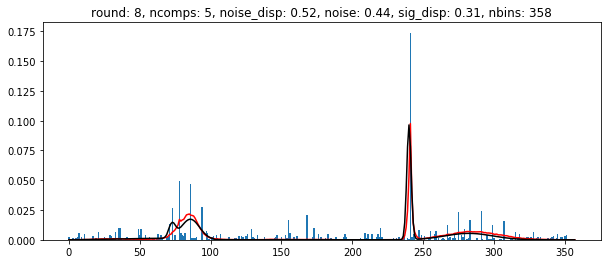

sim 4610/500000, loss: 0.2045, losses_av: 0.1545, tv: 0.00426, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0101, KL: 0.0884, nbins: 79
sim 4620/500000, loss: 0.2802, losses_av: 0.1547, tv: 0.00426, tv_trend: 0.00645,  shrink: 0.0287, ll: 0.0101, KL: 0.0885, nbins: 369
sim 4630/500000, loss: 0.0510, losses_av: 0.1546, tv: 0.00426, tv_trend: 0.00646,  shrink: 0.0286, ll: 0.0101, KL: 0.0886, nbins: 455
sim 4640/500000, loss: 0.1477, losses_av: 0.1546, tv: 0.00426, tv_trend: 0.00646,  shrink: 0.0287, ll: 0.0101, KL: 0.0886, nbins: 16
sim 4650/500000, loss: 0.2192, losses_av: 0.1545, tv: 0.00425, tv_trend: 0.00644,  shrink: 0.0287, ll: 0.0101, KL: 0.0886, nbins: 293
sim 4660/500000, loss: 0.2576, losses_av: 0.1545, tv: 0.00424, tv_trend: 0.00643,  shrink: 0.0286, ll: 0.0101, KL: 0.0885, nbins: 292
sim 4670/500000, loss: 0.2075, losses_av: 0.1546, tv: 0.00423, tv_trend: 0.00640,  shrink: 0.0286, ll: 0.0101, KL: 0.0886, nbins: 536
sim 4680/500000, loss: 0.1584, losses_av: 0.1545, tv: 0.00421, t

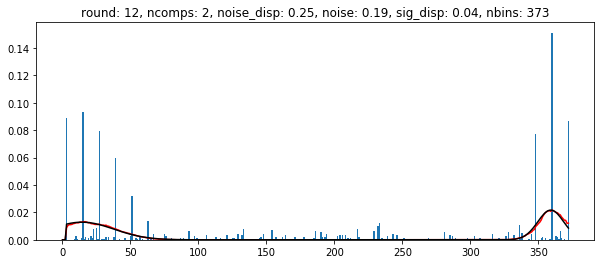

sim 4710/500000, loss: 0.3050, losses_av: 0.1544, tv: 0.00419, tv_trend: 0.00633,  shrink: 0.0287, ll: 0.0101, KL: 0.0886, nbins: 524
sim 4720/500000, loss: 0.0732, losses_av: 0.1542, tv: 0.00419, tv_trend: 0.00632,  shrink: 0.0287, ll: 0.0101, KL: 0.0885, nbins: 266
sim 4730/500000, loss: 0.1485, losses_av: 0.1542, tv: 0.00420, tv_trend: 0.00634,  shrink: 0.0288, ll: 0.0101, KL: 0.0885, nbins: 11
sim 4740/500000, loss: 0.2432, losses_av: 0.1544, tv: 0.00421, tv_trend: 0.00636,  shrink: 0.0288, ll: 0.0101, KL: 0.0886, nbins: 450
sim 4750/500000, loss: 0.0666, losses_av: 0.1546, tv: 0.00421, tv_trend: 0.00635,  shrink: 0.0289, ll: 0.0101, KL: 0.0886, nbins: 491
sim 4760/500000, loss: 0.1537, losses_av: 0.1545, tv: 0.00422, tv_trend: 0.00637,  shrink: 0.0290, ll: 0.0101, KL: 0.0886, nbins: 356
sim 4770/500000, loss: 0.2548, losses_av: 0.1544, tv: 0.00422, tv_trend: 0.00637,  shrink: 0.0290, ll: 0.0101, KL: 0.0885, nbins: 426
sim 4780/500000, loss: 0.2691, losses_av: 0.1543, tv: 0.00422, 

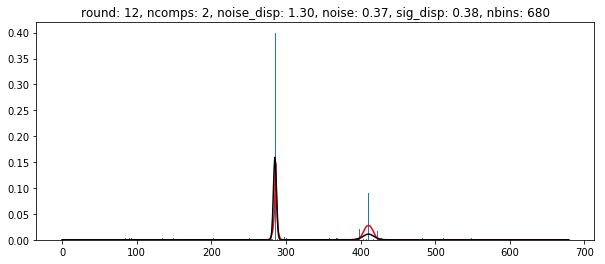

sim 4810/500000, loss: 0.2447, losses_av: 0.1541, tv: 0.00420, tv_trend: 0.00632,  shrink: 0.0289, ll: 0.0101, KL: 0.0885, nbins: 59
sim 4820/500000, loss: 0.2868, losses_av: 0.1542, tv: 0.00420, tv_trend: 0.00632,  shrink: 0.0290, ll: 0.0101, KL: 0.0885, nbins: 464
sim 4830/500000, loss: 0.1623, losses_av: 0.1541, tv: 0.00419, tv_trend: 0.00630,  shrink: 0.0290, ll: 0.0101, KL: 0.0885, nbins: 51
sim 4840/500000, loss: 0.1179, losses_av: 0.1540, tv: 0.00419, tv_trend: 0.00630,  shrink: 0.0290, ll: 0.0101, KL: 0.0886, nbins: 496
sim 4850/500000, loss: 0.0634, losses_av: 0.1536, tv: 0.00418, tv_trend: 0.00628,  shrink: 0.0289, ll: 0.0101, KL: 0.0884, nbins: 227
sim 4860/500000, loss: 0.0730, losses_av: 0.1538, tv: 0.00418, tv_trend: 0.00629,  shrink: 0.0289, ll: 0.0101, KL: 0.0885, nbins: 396
sim 4870/500000, loss: 0.0679, losses_av: 0.1536, tv: 0.00418, tv_trend: 0.00629,  shrink: 0.0289, ll: 0.0101, KL: 0.0884, nbins: 125
sim 4880/500000, loss: 0.0537, losses_av: 0.1534, tv: 0.00417, t

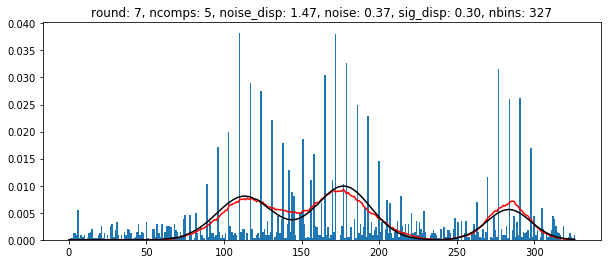

sim 4910/500000, loss: 0.0598, losses_av: 0.1537, tv: 0.00419, tv_trend: 0.00630,  shrink: 0.0290, ll: 0.0101, KL: 0.0884, nbins: 218
sim 4920/500000, loss: 0.0969, losses_av: 0.1532, tv: 0.00417, tv_trend: 0.00627,  shrink: 0.0289, ll: 0.0100, KL: 0.0882, nbins: 440
sim 4930/500000, loss: 0.1089, losses_av: 0.1537, tv: 0.00419, tv_trend: 0.00630,  shrink: 0.0290, ll: 0.0101, KL: 0.0885, nbins: 131
sim 4940/500000, loss: 0.2686, losses_av: 0.1540, tv: 0.00421, tv_trend: 0.00632,  shrink: 0.0289, ll: 0.0101, KL: 0.0886, nbins: 269
sim 4950/500000, loss: 0.1328, losses_av: 0.1536, tv: 0.00420, tv_trend: 0.00631,  shrink: 0.0289, ll: 0.0101, KL: 0.0885, nbins: 446
sim 4960/500000, loss: 0.0537, losses_av: 0.1531, tv: 0.00418, tv_trend: 0.00628,  shrink: 0.0289, ll: 0.0100, KL: 0.0883, nbins: 512
sim 4970/500000, loss: 0.2361, losses_av: 0.1528, tv: 0.00416, tv_trend: 0.00625,  shrink: 0.0288, ll: 0.0100, KL: 0.0882, nbins: 252
sim 4980/500000, loss: 0.0686, losses_av: 0.1528, tv: 0.00416,

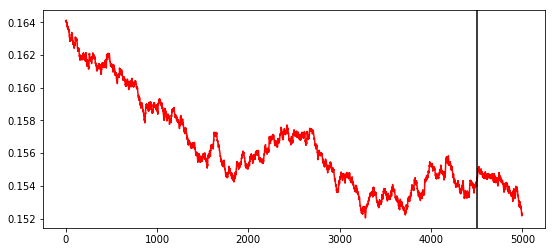

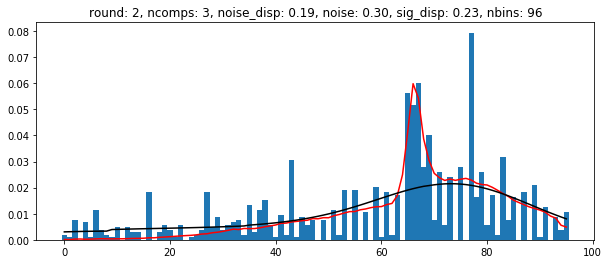

sim 5010/500000, loss: 0.1900, losses_av: 0.1520, tv: 0.00414, tv_trend: 0.00621,  shrink: 0.0287, ll: 0.0099, KL: 0.0877, nbins: 407
sim 5020/500000, loss: 0.1135, losses_av: 0.1517, tv: 0.00413, tv_trend: 0.00620,  shrink: 0.0286, ll: 0.0099, KL: 0.0876, nbins: 448
sim 5030/500000, loss: 0.1292, losses_av: 0.1516, tv: 0.00413, tv_trend: 0.00620,  shrink: 0.0287, ll: 0.0099, KL: 0.0876, nbins: 102
sim 5040/500000, loss: 0.0752, losses_av: 0.1509, tv: 0.00411, tv_trend: 0.00617,  shrink: 0.0286, ll: 0.0098, KL: 0.0873, nbins: 562
sim 5050/500000, loss: 0.0875, losses_av: 0.1512, tv: 0.00412, tv_trend: 0.00618,  shrink: 0.0286, ll: 0.0098, KL: 0.0875, nbins: 543
sim 5060/500000, loss: 0.1401, losses_av: 0.1512, tv: 0.00412, tv_trend: 0.00617,  shrink: 0.0287, ll: 0.0098, KL: 0.0874, nbins: 25
sim 5070/500000, loss: 0.1861, losses_av: 0.1513, tv: 0.00411, tv_trend: 0.00616,  shrink: 0.0286, ll: 0.0099, KL: 0.0874, nbins: 181
sim 5080/500000, loss: 0.3778, losses_av: 0.1514, tv: 0.00412, 

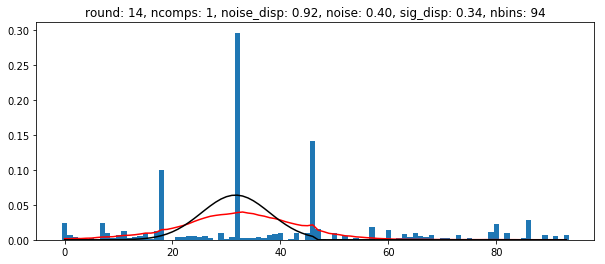

sim 5110/500000, loss: 0.2041, losses_av: 0.1515, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0287, ll: 0.0099, KL: 0.0875, nbins: 248
sim 5120/500000, loss: 0.2535, losses_av: 0.1519, tv: 0.00412, tv_trend: 0.00616,  shrink: 0.0287, ll: 0.0099, KL: 0.0876, nbins: 437
sim 5130/500000, loss: 0.1899, losses_av: 0.1523, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0288, ll: 0.0100, KL: 0.0878, nbins: 224
sim 5140/500000, loss: 0.1694, losses_av: 0.1522, tv: 0.00412, tv_trend: 0.00616,  shrink: 0.0288, ll: 0.0100, KL: 0.0877, nbins: 208
sim 5150/500000, loss: 0.0839, losses_av: 0.1523, tv: 0.00413, tv_trend: 0.00617,  shrink: 0.0288, ll: 0.0100, KL: 0.0877, nbins: 558
sim 5160/500000, loss: 0.1134, losses_av: 0.1521, tv: 0.00413, tv_trend: 0.00617,  shrink: 0.0288, ll: 0.0100, KL: 0.0876, nbins: 167
sim 5170/500000, loss: 0.2128, losses_av: 0.1515, tv: 0.00411, tv_trend: 0.00613,  shrink: 0.0287, ll: 0.0099, KL: 0.0873, nbins: 495
sim 5180/500000, loss: 0.1792, losses_av: 0.1519, tv: 0.00411,

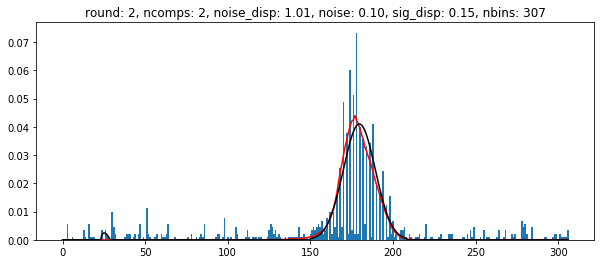

sim 5210/500000, loss: 0.0942, losses_av: 0.1515, tv: 0.00412, tv_trend: 0.00614,  shrink: 0.0287, ll: 0.0099, KL: 0.0872, nbins: 460
sim 5220/500000, loss: 0.2709, losses_av: 0.1520, tv: 0.00412, tv_trend: 0.00614,  shrink: 0.0287, ll: 0.0100, KL: 0.0874, nbins: 168
sim 5230/500000, loss: 0.2538, losses_av: 0.1520, tv: 0.00411, tv_trend: 0.00613,  shrink: 0.0287, ll: 0.0100, KL: 0.0874, nbins: 169
sim 5240/500000, loss: 0.1211, losses_av: 0.1518, tv: 0.00411, tv_trend: 0.00611,  shrink: 0.0287, ll: 0.0100, KL: 0.0873, nbins: 98
sim 5250/500000, loss: 0.1147, losses_av: 0.1522, tv: 0.00412, tv_trend: 0.00613,  shrink: 0.0287, ll: 0.0100, KL: 0.0875, nbins: 80
sim 5260/500000, loss: 0.1742, losses_av: 0.1520, tv: 0.00412, tv_trend: 0.00614,  shrink: 0.0287, ll: 0.0100, KL: 0.0874, nbins: 111
sim 5270/500000, loss: 0.1438, losses_av: 0.1518, tv: 0.00411, tv_trend: 0.00612,  shrink: 0.0286, ll: 0.0100, KL: 0.0873, nbins: 307
sim 5280/500000, loss: 0.0784, losses_av: 0.1518, tv: 0.00410, t

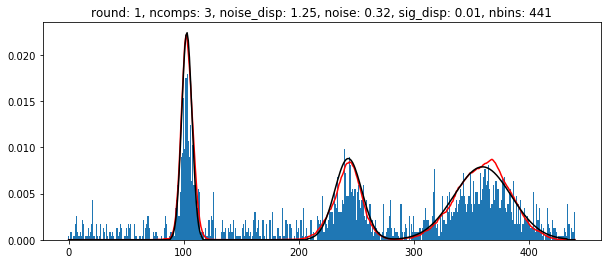

sim 5310/500000, loss: 0.0822, losses_av: 0.1517, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0286, ll: 0.0100, KL: 0.0872, nbins: 368
sim 5320/500000, loss: 0.1751, losses_av: 0.1516, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0286, ll: 0.0100, KL: 0.0872, nbins: 490
sim 5330/500000, loss: 0.1195, losses_av: 0.1516, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0287, ll: 0.0099, KL: 0.0872, nbins: 23
sim 5340/500000, loss: 0.0964, losses_av: 0.1514, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0287, ll: 0.0099, KL: 0.0872, nbins: 584
sim 5350/500000, loss: 0.1122, losses_av: 0.1513, tv: 0.00413, tv_trend: 0.00616,  shrink: 0.0287, ll: 0.0099, KL: 0.0871, nbins: 443
sim 5360/500000, loss: 0.0723, losses_av: 0.1510, tv: 0.00411, tv_trend: 0.00613,  shrink: 0.0287, ll: 0.0099, KL: 0.0871, nbins: 210
sim 5370/500000, loss: 0.1296, losses_av: 0.1511, tv: 0.00410, tv_trend: 0.00612,  shrink: 0.0287, ll: 0.0099, KL: 0.0872, nbins: 155
sim 5380/500000, loss: 0.2161, losses_av: 0.1513, tv: 0.00409, 

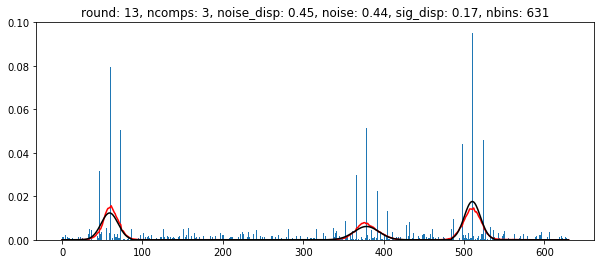

sim 5410/500000, loss: 0.1132, losses_av: 0.1513, tv: 0.00410, tv_trend: 0.00611,  shrink: 0.0287, ll: 0.0099, KL: 0.0873, nbins: 389
sim 5420/500000, loss: 0.3292, losses_av: 0.1517, tv: 0.00412, tv_trend: 0.00615,  shrink: 0.0287, ll: 0.0099, KL: 0.0875, nbins: 109
sim 5430/500000, loss: 0.1818, losses_av: 0.1523, tv: 0.00414, tv_trend: 0.00619,  shrink: 0.0288, ll: 0.0100, KL: 0.0876, nbins: 274
sim 5440/500000, loss: 0.1343, losses_av: 0.1523, tv: 0.00415, tv_trend: 0.00620,  shrink: 0.0288, ll: 0.0100, KL: 0.0876, nbins: 574
sim 5450/500000, loss: 0.1071, losses_av: 0.1524, tv: 0.00414, tv_trend: 0.00618,  shrink: 0.0287, ll: 0.0100, KL: 0.0877, nbins: 422
sim 5460/500000, loss: 0.0834, losses_av: 0.1524, tv: 0.00415, tv_trend: 0.00618,  shrink: 0.0288, ll: 0.0100, KL: 0.0876, nbins: 280
sim 5470/500000, loss: 0.2377, losses_av: 0.1524, tv: 0.00415, tv_trend: 0.00618,  shrink: 0.0289, ll: 0.0100, KL: 0.0876, nbins: 186
sim 5480/500000, loss: 0.1460, losses_av: 0.1525, tv: 0.00415,

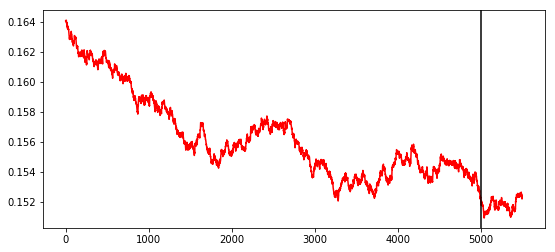

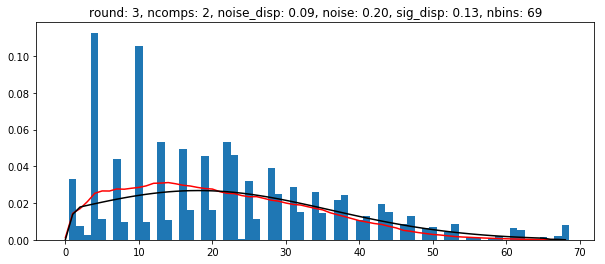

sim 5510/500000, loss: 0.0746, losses_av: 0.1523, tv: 0.00416, tv_trend: 0.00621,  shrink: 0.0289, ll: 0.0100, KL: 0.0876, nbins: 83
sim 5520/500000, loss: 0.1190, losses_av: 0.1524, tv: 0.00416, tv_trend: 0.00622,  shrink: 0.0289, ll: 0.0100, KL: 0.0876, nbins: 301
sim 5530/500000, loss: 0.1169, losses_av: 0.1526, tv: 0.00417, tv_trend: 0.00622,  shrink: 0.0289, ll: 0.0101, KL: 0.0877, nbins: 537
sim 5540/500000, loss: 0.0728, losses_av: 0.1526, tv: 0.00418, tv_trend: 0.00623,  shrink: 0.0289, ll: 0.0101, KL: 0.0876, nbins: 184
sim 5550/500000, loss: 0.3538, losses_av: 0.1529, tv: 0.00418, tv_trend: 0.00625,  shrink: 0.0289, ll: 0.0101, KL: 0.0877, nbins: 248
sim 5560/500000, loss: 0.1791, losses_av: 0.1535, tv: 0.00421, tv_trend: 0.00629,  shrink: 0.0290, ll: 0.0102, KL: 0.0879, nbins: 170
sim 5570/500000, loss: 0.0829, losses_av: 0.1535, tv: 0.00423, tv_trend: 0.00632,  shrink: 0.0290, ll: 0.0102, KL: 0.0878, nbins: 336
sim 5580/500000, loss: 0.0979, losses_av: 0.1532, tv: 0.00421, 

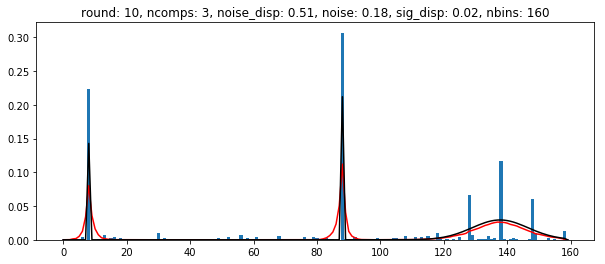

sim 5610/500000, loss: 0.0691, losses_av: 0.1535, tv: 0.00423, tv_trend: 0.00635,  shrink: 0.0290, ll: 0.0102, KL: 0.0879, nbins: 386
sim 5620/500000, loss: 0.2734, losses_av: 0.1536, tv: 0.00425, tv_trend: 0.00637,  shrink: 0.0291, ll: 0.0102, KL: 0.0880, nbins: 472
sim 5630/500000, loss: 0.0910, losses_av: 0.1538, tv: 0.00426, tv_trend: 0.00638,  shrink: 0.0291, ll: 0.0102, KL: 0.0880, nbins: 213
sim 5640/500000, loss: 0.0735, losses_av: 0.1533, tv: 0.00424, tv_trend: 0.00636,  shrink: 0.0291, ll: 0.0102, KL: 0.0878, nbins: 186
sim 5650/500000, loss: 0.2252, losses_av: 0.1529, tv: 0.00423, tv_trend: 0.00633,  shrink: 0.0290, ll: 0.0101, KL: 0.0876, nbins: 294
sim 5660/500000, loss: 0.1433, losses_av: 0.1535, tv: 0.00424, tv_trend: 0.00633,  shrink: 0.0293, ll: 0.0102, KL: 0.0878, nbins: 462
sim 5670/500000, loss: 0.1029, losses_av: 0.1533, tv: 0.00423, tv_trend: 0.00631,  shrink: 0.0293, ll: 0.0102, KL: 0.0879, nbins: 141
sim 5680/500000, loss: 0.2450, losses_av: 0.1536, tv: 0.00424,

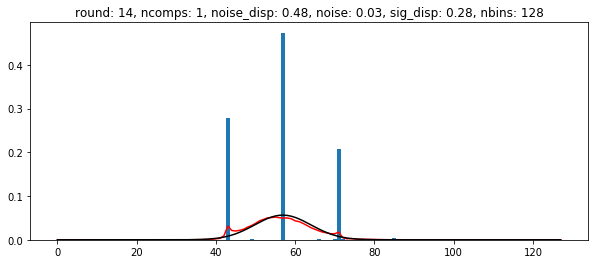

sim 5710/500000, loss: 0.0864, losses_av: 0.1538, tv: 0.00426, tv_trend: 0.00636,  shrink: 0.0292, ll: 0.0102, KL: 0.0881, nbins: 49
sim 5720/500000, loss: 0.1848, losses_av: 0.1536, tv: 0.00426, tv_trend: 0.00637,  shrink: 0.0292, ll: 0.0102, KL: 0.0880, nbins: 111
sim 5730/500000, loss: 0.1341, losses_av: 0.1537, tv: 0.00426, tv_trend: 0.00637,  shrink: 0.0292, ll: 0.0102, KL: 0.0880, nbins: 43
sim 5740/500000, loss: 0.2907, losses_av: 0.1540, tv: 0.00427, tv_trend: 0.00639,  shrink: 0.0293, ll: 0.0103, KL: 0.0881, nbins: 239
sim 5750/500000, loss: 0.1753, losses_av: 0.1540, tv: 0.00427, tv_trend: 0.00639,  shrink: 0.0293, ll: 0.0103, KL: 0.0881, nbins: 331
sim 5760/500000, loss: 0.1221, losses_av: 0.1540, tv: 0.00428, tv_trend: 0.00640,  shrink: 0.0293, ll: 0.0103, KL: 0.0882, nbins: 299
sim 5770/500000, loss: 0.2442, losses_av: 0.1543, tv: 0.00429, tv_trend: 0.00641,  shrink: 0.0294, ll: 0.0103, KL: 0.0883, nbins: 329
sim 5780/500000, loss: 0.1907, losses_av: 0.1539, tv: 0.00428, t

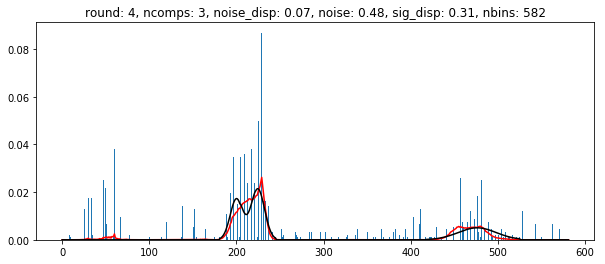

sim 5810/500000, loss: 0.0686, losses_av: 0.1541, tv: 0.00428, tv_trend: 0.00638,  shrink: 0.0294, ll: 0.0103, KL: 0.0882, nbins: 389
sim 5820/500000, loss: 0.0353, losses_av: 0.1540, tv: 0.00428, tv_trend: 0.00639,  shrink: 0.0293, ll: 0.0103, KL: 0.0881, nbins: 511
sim 5830/500000, loss: 0.3499, losses_av: 0.1548, tv: 0.00429, tv_trend: 0.00642,  shrink: 0.0293, ll: 0.0103, KL: 0.0884, nbins: 209
sim 5840/500000, loss: 0.0756, losses_av: 0.1549, tv: 0.00430, tv_trend: 0.00643,  shrink: 0.0293, ll: 0.0104, KL: 0.0883, nbins: 362
sim 5850/500000, loss: 0.1508, losses_av: 0.1551, tv: 0.00430, tv_trend: 0.00644,  shrink: 0.0293, ll: 0.0104, KL: 0.0885, nbins: 564
sim 5860/500000, loss: 0.2433, losses_av: 0.1548, tv: 0.00429, tv_trend: 0.00643,  shrink: 0.0293, ll: 0.0103, KL: 0.0884, nbins: 37
sim 5870/500000, loss: 0.1710, losses_av: 0.1546, tv: 0.00429, tv_trend: 0.00643,  shrink: 0.0293, ll: 0.0103, KL: 0.0883, nbins: 292
sim 5880/500000, loss: 0.0709, losses_av: 0.1545, tv: 0.00429, 

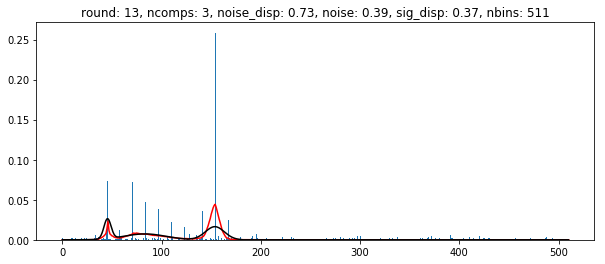

sim 5910/500000, loss: 0.0788, losses_av: 0.1548, tv: 0.00432, tv_trend: 0.00646,  shrink: 0.0293, ll: 0.0103, KL: 0.0884, nbins: 386
sim 5920/500000, loss: 0.1694, losses_av: 0.1551, tv: 0.00432, tv_trend: 0.00646,  shrink: 0.0293, ll: 0.0103, KL: 0.0887, nbins: 291
sim 5930/500000, loss: 0.1413, losses_av: 0.1549, tv: 0.00431, tv_trend: 0.00643,  shrink: 0.0292, ll: 0.0103, KL: 0.0886, nbins: 355
sim 5940/500000, loss: 0.1987, losses_av: 0.1550, tv: 0.00431, tv_trend: 0.00644,  shrink: 0.0292, ll: 0.0103, KL: 0.0887, nbins: 327
sim 5950/500000, loss: 0.1646, losses_av: 0.1552, tv: 0.00431, tv_trend: 0.00644,  shrink: 0.0292, ll: 0.0103, KL: 0.0888, nbins: 465
sim 5960/500000, loss: 0.1237, losses_av: 0.1550, tv: 0.00430, tv_trend: 0.00643,  shrink: 0.0292, ll: 0.0103, KL: 0.0888, nbins: 469
sim 5970/500000, loss: 0.2638, losses_av: 0.1559, tv: 0.00433, tv_trend: 0.00649,  shrink: 0.0292, ll: 0.0104, KL: 0.0890, nbins: 437
sim 5980/500000, loss: 0.2235, losses_av: 0.1557, tv: 0.00432,

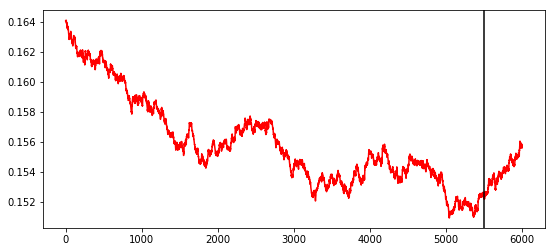

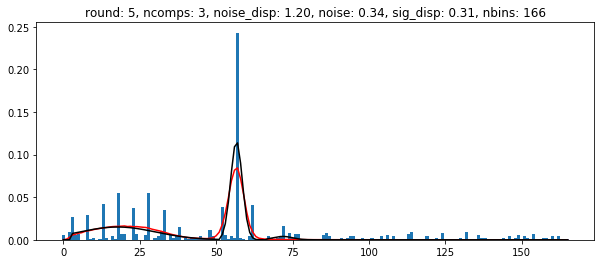

sim 6010/500000, loss: 0.1788, losses_av: 0.1556, tv: 0.00430, tv_trend: 0.00644,  shrink: 0.0290, ll: 0.0103, KL: 0.0890, nbins: 422
sim 6020/500000, loss: 0.2268, losses_av: 0.1559, tv: 0.00430, tv_trend: 0.00644,  shrink: 0.0290, ll: 0.0104, KL: 0.0892, nbins: 175
sim 6030/500000, loss: 0.1914, losses_av: 0.1559, tv: 0.00430, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0104, KL: 0.0891, nbins: 365
sim 6040/500000, loss: 0.0734, losses_av: 0.1557, tv: 0.00430, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0104, KL: 0.0890, nbins: 407
sim 6050/500000, loss: 0.1278, losses_av: 0.1556, tv: 0.00429, tv_trend: 0.00645,  shrink: 0.0289, ll: 0.0104, KL: 0.0890, nbins: 300
sim 6060/500000, loss: 0.2054, losses_av: 0.1554, tv: 0.00430, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0103, KL: 0.0889, nbins: 17
sim 6070/500000, loss: 0.0633, losses_av: 0.1554, tv: 0.00430, tv_trend: 0.00646,  shrink: 0.0289, ll: 0.0103, KL: 0.0889, nbins: 452
sim 6080/500000, loss: 0.1595, losses_av: 0.1554, tv: 0.00428, 

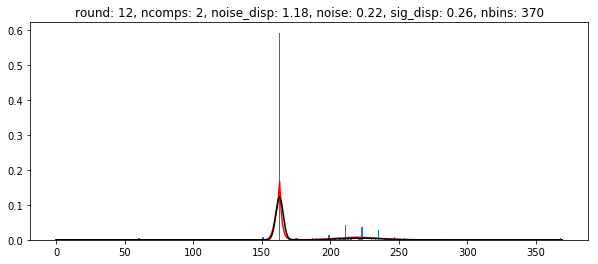

sim 6110/500000, loss: 0.1483, losses_av: 0.1549, tv: 0.00429, tv_trend: 0.00648,  shrink: 0.0289, ll: 0.0103, KL: 0.0887, nbins: 184
sim 6120/500000, loss: 0.0841, losses_av: 0.1549, tv: 0.00429, tv_trend: 0.00648,  shrink: 0.0288, ll: 0.0103, KL: 0.0888, nbins: 489
sim 6130/500000, loss: 0.0480, losses_av: 0.1550, tv: 0.00431, tv_trend: 0.00652,  shrink: 0.0288, ll: 0.0103, KL: 0.0887, nbins: 172
sim 6140/500000, loss: 0.0909, losses_av: 0.1551, tv: 0.00433, tv_trend: 0.00655,  shrink: 0.0289, ll: 0.0103, KL: 0.0887, nbins: 200
sim 6150/500000, loss: 0.0779, losses_av: 0.1549, tv: 0.00433, tv_trend: 0.00654,  shrink: 0.0289, ll: 0.0103, KL: 0.0887, nbins: 303
sim 6160/500000, loss: 0.1006, losses_av: 0.1555, tv: 0.00433, tv_trend: 0.00655,  shrink: 0.0289, ll: 0.0103, KL: 0.0889, nbins: 437
sim 6170/500000, loss: 0.1724, losses_av: 0.1552, tv: 0.00432, tv_trend: 0.00654,  shrink: 0.0289, ll: 0.0103, KL: 0.0888, nbins: 428
sim 6180/500000, loss: 0.0885, losses_av: 0.1550, tv: 0.00432,

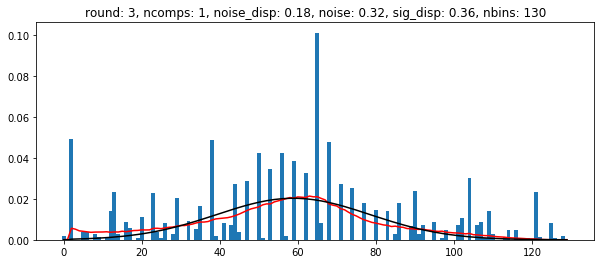

sim 6210/500000, loss: 0.2484, losses_av: 0.1557, tv: 0.00436, tv_trend: 0.00660,  shrink: 0.0290, ll: 0.0103, KL: 0.0890, nbins: 83
sim 6220/500000, loss: 0.0989, losses_av: 0.1552, tv: 0.00435, tv_trend: 0.00658,  shrink: 0.0290, ll: 0.0103, KL: 0.0888, nbins: 399
sim 6230/500000, loss: 0.1574, losses_av: 0.1551, tv: 0.00437, tv_trend: 0.00661,  shrink: 0.0290, ll: 0.0103, KL: 0.0888, nbins: 425
sim 6240/500000, loss: 0.3678, losses_av: 0.1552, tv: 0.00436, tv_trend: 0.00660,  shrink: 0.0290, ll: 0.0103, KL: 0.0888, nbins: 484
sim 6250/500000, loss: 0.2960, losses_av: 0.1552, tv: 0.00436, tv_trend: 0.00659,  shrink: 0.0290, ll: 0.0103, KL: 0.0889, nbins: 78
sim 6260/500000, loss: 0.0972, losses_av: 0.1551, tv: 0.00435, tv_trend: 0.00658,  shrink: 0.0290, ll: 0.0102, KL: 0.0889, nbins: 136
sim 6270/500000, loss: 0.0975, losses_av: 0.1552, tv: 0.00435, tv_trend: 0.00658,  shrink: 0.0290, ll: 0.0103, KL: 0.0889, nbins: 371
sim 6280/500000, loss: 0.1637, losses_av: 0.1551, tv: 0.00436, t

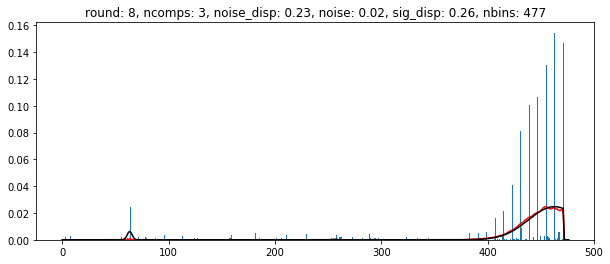

sim 6310/500000, loss: 0.1814, losses_av: 0.1552, tv: 0.00437, tv_trend: 0.00660,  shrink: 0.0290, ll: 0.0103, KL: 0.0888, nbins: 165
sim 6320/500000, loss: 0.1156, losses_av: 0.1550, tv: 0.00436, tv_trend: 0.00659,  shrink: 0.0290, ll: 0.0103, KL: 0.0887, nbins: 198
sim 6330/500000, loss: 0.3605, losses_av: 0.1553, tv: 0.00436, tv_trend: 0.00659,  shrink: 0.0290, ll: 0.0103, KL: 0.0887, nbins: 87
sim 6340/500000, loss: 0.1248, losses_av: 0.1552, tv: 0.00436, tv_trend: 0.00659,  shrink: 0.0291, ll: 0.0103, KL: 0.0886, nbins: 34
sim 6350/500000, loss: 0.2271, losses_av: 0.1555, tv: 0.00438, tv_trend: 0.00662,  shrink: 0.0290, ll: 0.0103, KL: 0.0887, nbins: 442
sim 6360/500000, loss: 0.1058, losses_av: 0.1553, tv: 0.00437, tv_trend: 0.00660,  shrink: 0.0290, ll: 0.0103, KL: 0.0888, nbins: 577
sim 6370/500000, loss: 0.1799, losses_av: 0.1551, tv: 0.00436, tv_trend: 0.00659,  shrink: 0.0290, ll: 0.0103, KL: 0.0887, nbins: 515
sim 6380/500000, loss: 0.1645, losses_av: 0.1548, tv: 0.00435, t

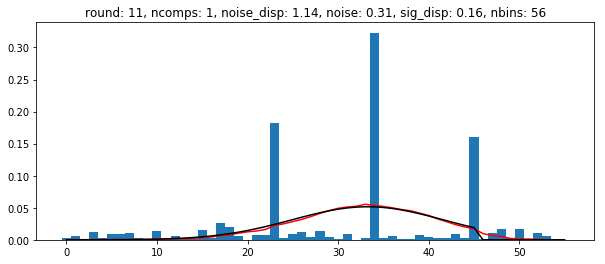

sim 6410/500000, loss: 0.1505, losses_av: 0.1545, tv: 0.00433, tv_trend: 0.00653,  shrink: 0.0290, ll: 0.0102, KL: 0.0885, nbins: 278
sim 6420/500000, loss: 0.1869, losses_av: 0.1543, tv: 0.00432, tv_trend: 0.00653,  shrink: 0.0290, ll: 0.0102, KL: 0.0885, nbins: 270
sim 6430/500000, loss: 0.0656, losses_av: 0.1540, tv: 0.00432, tv_trend: 0.00651,  shrink: 0.0290, ll: 0.0102, KL: 0.0884, nbins: 386
sim 6440/500000, loss: 0.0585, losses_av: 0.1539, tv: 0.00431, tv_trend: 0.00649,  shrink: 0.0289, ll: 0.0102, KL: 0.0883, nbins: 554
sim 6450/500000, loss: 0.1570, losses_av: 0.1539, tv: 0.00429, tv_trend: 0.00647,  shrink: 0.0289, ll: 0.0102, KL: 0.0883, nbins: 447
sim 6460/500000, loss: 0.0907, losses_av: 0.1538, tv: 0.00428, tv_trend: 0.00645,  shrink: 0.0288, ll: 0.0102, KL: 0.0883, nbins: 507
sim 6470/500000, loss: 0.0680, losses_av: 0.1535, tv: 0.00428, tv_trend: 0.00645,  shrink: 0.0288, ll: 0.0101, KL: 0.0881, nbins: 313
sim 6480/500000, loss: 0.1040, losses_av: 0.1532, tv: 0.00427,

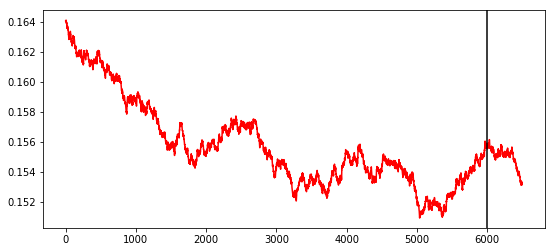

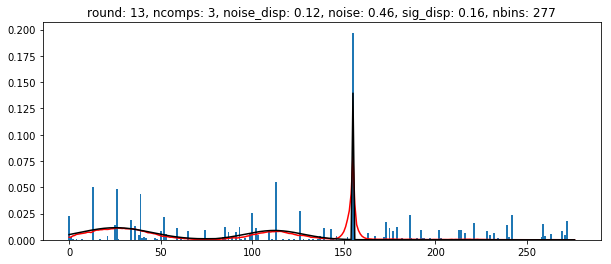

sim 6510/500000, loss: 0.1335, losses_av: 0.1533, tv: 0.00429, tv_trend: 0.00646,  shrink: 0.0289, ll: 0.0101, KL: 0.0880, nbins: 548
sim 6520/500000, loss: 0.0737, losses_av: 0.1533, tv: 0.00429, tv_trend: 0.00646,  shrink: 0.0288, ll: 0.0101, KL: 0.0879, nbins: 148
sim 6530/500000, loss: 0.1194, losses_av: 0.1529, tv: 0.00428, tv_trend: 0.00644,  shrink: 0.0288, ll: 0.0101, KL: 0.0878, nbins: 439
sim 6540/500000, loss: 0.2089, losses_av: 0.1531, tv: 0.00430, tv_trend: 0.00647,  shrink: 0.0288, ll: 0.0101, KL: 0.0878, nbins: 359
sim 6550/500000, loss: 0.0840, losses_av: 0.1532, tv: 0.00430, tv_trend: 0.00648,  shrink: 0.0288, ll: 0.0101, KL: 0.0878, nbins: 183
sim 6560/500000, loss: 0.1594, losses_av: 0.1532, tv: 0.00429, tv_trend: 0.00646,  shrink: 0.0289, ll: 0.0101, KL: 0.0878, nbins: 20
sim 6570/500000, loss: 0.0482, losses_av: 0.1530, tv: 0.00429, tv_trend: 0.00645,  shrink: 0.0289, ll: 0.0101, KL: 0.0877, nbins: 159
sim 6580/500000, loss: 0.0676, losses_av: 0.1526, tv: 0.00429, 

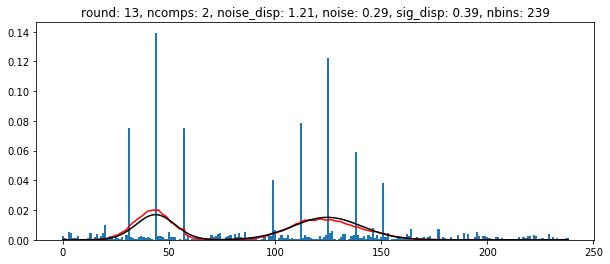

sim 6610/500000, loss: 0.1100, losses_av: 0.1531, tv: 0.00430, tv_trend: 0.00646,  shrink: 0.0290, ll: 0.0101, KL: 0.0878, nbins: 113
sim 6620/500000, loss: 0.0728, losses_av: 0.1529, tv: 0.00429, tv_trend: 0.00645,  shrink: 0.0290, ll: 0.0101, KL: 0.0877, nbins: 461
sim 6630/500000, loss: 0.1479, losses_av: 0.1532, tv: 0.00431, tv_trend: 0.00648,  shrink: 0.0290, ll: 0.0101, KL: 0.0878, nbins: 518
sim 6640/500000, loss: 0.1488, losses_av: 0.1530, tv: 0.00430, tv_trend: 0.00648,  shrink: 0.0290, ll: 0.0101, KL: 0.0877, nbins: 63
sim 6650/500000, loss: 0.0867, losses_av: 0.1526, tv: 0.00429, tv_trend: 0.00645,  shrink: 0.0289, ll: 0.0101, KL: 0.0875, nbins: 251
sim 6660/500000, loss: 0.2230, losses_av: 0.1524, tv: 0.00428, tv_trend: 0.00644,  shrink: 0.0290, ll: 0.0100, KL: 0.0875, nbins: 147
sim 6670/500000, loss: 0.1034, losses_av: 0.1523, tv: 0.00429, tv_trend: 0.00644,  shrink: 0.0290, ll: 0.0100, KL: 0.0875, nbins: 122
sim 6680/500000, loss: 0.3527, losses_av: 0.1524, tv: 0.00429, 

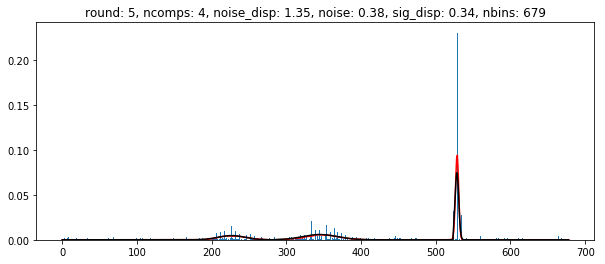

sim 6710/500000, loss: 0.1477, losses_av: 0.1530, tv: 0.00432, tv_trend: 0.00650,  shrink: 0.0290, ll: 0.0101, KL: 0.0877, nbins: 223
sim 6720/500000, loss: 0.0804, losses_av: 0.1530, tv: 0.00432, tv_trend: 0.00651,  shrink: 0.0290, ll: 0.0101, KL: 0.0878, nbins: 278
sim 6730/500000, loss: 0.3253, losses_av: 0.1536, tv: 0.00434, tv_trend: 0.00653,  shrink: 0.0290, ll: 0.0101, KL: 0.0880, nbins: 469
sim 6740/500000, loss: 0.0703, losses_av: 0.1534, tv: 0.00433, tv_trend: 0.00651,  shrink: 0.0290, ll: 0.0101, KL: 0.0879, nbins: 439
sim 6750/500000, loss: 0.1732, losses_av: 0.1531, tv: 0.00432, tv_trend: 0.00649,  shrink: 0.0290, ll: 0.0101, KL: 0.0877, nbins: 206
sim 6760/500000, loss: 0.0982, losses_av: 0.1533, tv: 0.00433, tv_trend: 0.00650,  shrink: 0.0290, ll: 0.0101, KL: 0.0879, nbins: 61
sim 6770/500000, loss: 0.2197, losses_av: 0.1532, tv: 0.00432, tv_trend: 0.00649,  shrink: 0.0290, ll: 0.0101, KL: 0.0879, nbins: 97
sim 6780/500000, loss: 0.0958, losses_av: 0.1534, tv: 0.00432, t

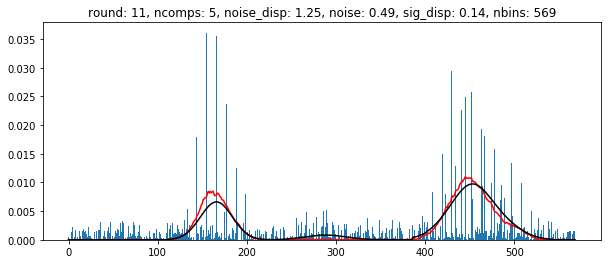

sim 6810/500000, loss: 0.0949, losses_av: 0.1535, tv: 0.00436, tv_trend: 0.00652,  shrink: 0.0292, ll: 0.0101, KL: 0.0877, nbins: 502
sim 6820/500000, loss: 0.2172, losses_av: 0.1537, tv: 0.00437, tv_trend: 0.00654,  shrink: 0.0293, ll: 0.0102, KL: 0.0877, nbins: 51
sim 6830/500000, loss: 0.1468, losses_av: 0.1538, tv: 0.00438, tv_trend: 0.00656,  shrink: 0.0293, ll: 0.0102, KL: 0.0877, nbins: 345
sim 6840/500000, loss: 0.1044, losses_av: 0.1536, tv: 0.00437, tv_trend: 0.00654,  shrink: 0.0293, ll: 0.0102, KL: 0.0877, nbins: 133
sim 6850/500000, loss: 0.2163, losses_av: 0.1534, tv: 0.00436, tv_trend: 0.00654,  shrink: 0.0293, ll: 0.0101, KL: 0.0876, nbins: 468
sim 6860/500000, loss: 0.2559, losses_av: 0.1541, tv: 0.00438, tv_trend: 0.00657,  shrink: 0.0293, ll: 0.0102, KL: 0.0878, nbins: 99
sim 6870/500000, loss: 0.1677, losses_av: 0.1543, tv: 0.00439, tv_trend: 0.00658,  shrink: 0.0293, ll: 0.0102, KL: 0.0879, nbins: 40
sim 6880/500000, loss: 0.2370, losses_av: 0.1542, tv: 0.00439, tv

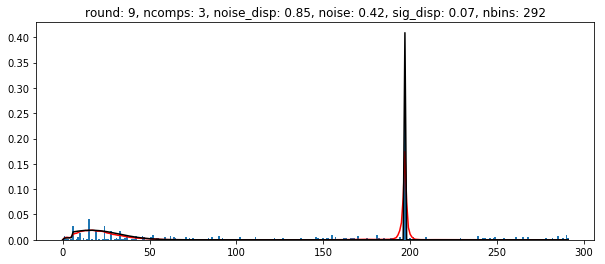

sim 6910/500000, loss: 0.2100, losses_av: 0.1548, tv: 0.00439, tv_trend: 0.00659,  shrink: 0.0294, ll: 0.0102, KL: 0.0885, nbins: 520
sim 6920/500000, loss: 0.0563, losses_av: 0.1550, tv: 0.00439, tv_trend: 0.00658,  shrink: 0.0294, ll: 0.0103, KL: 0.0886, nbins: 457
sim 6930/500000, loss: 0.1620, losses_av: 0.1554, tv: 0.00439, tv_trend: 0.00659,  shrink: 0.0294, ll: 0.0103, KL: 0.0888, nbins: 404
sim 6940/500000, loss: 0.1388, losses_av: 0.1556, tv: 0.00440, tv_trend: 0.00660,  shrink: 0.0294, ll: 0.0104, KL: 0.0888, nbins: 271
sim 6950/500000, loss: 0.1885, losses_av: 0.1555, tv: 0.00441, tv_trend: 0.00662,  shrink: 0.0294, ll: 0.0103, KL: 0.0888, nbins: 108


KeyboardInterrupt: 

In [11]:
first_run = 0

generator = RecordGenerator(n_obs=(500, 5000),
                            n_bins=(10, 700),
                            noise_ratio=(0.01, 0.5),
                            noise_dispersion=(0.05, 1.5),
                            rounding=list(range(1, 15)),
                            max_sigma_to_bins_ratio=0.25,
                            trim_corners=True)
nsims = 500000
X = []
Y = []
losses = []
lamb = 0.001
losses_av = []

bsize = 32

for sim in range(nsims):
    n_bins = np.random.randint(10, 601)
    Xbatch = []
    Ybatch = []
    for _ in range(bsize):
        data = generator.generate(n_bins=n_bins)
        x = np.array(data['counts'], dtype=np.float32)
        x /= x.sum()
        Xbatch.append(x)
        y = data['signal_normalized']
#         plt.plot(y)
#         plt.show()
#         print(y)
        Ybatch.append(y)
    Xbatch = tf.constant(np.expand_dims(np.stack(Xbatch, 0), -1), tf.float32)
    Ybatch = tf.constant(np.expand_dims(np.stack(Ybatch, 0), -1), tf.float32)
    loss = model.train_on_batch(Xbatch, Ybatch)
    losses.append(float(loss))
    if sim == 0:
        yhat = model(Xbatch)
        if first_run == 0:
            first_run = 1
            loss_ = loss
            losses_av = [loss_]
            tv_ = tv2(yhat)
            tv_trend_ = tv_trend(yhat)
            kl_ = kl(Ybatch, yhat)
            shrink_ = ridge(yhat)
            ll_ = llhood(Ybatch, yhat)
        else:
            losses_av = [loss_]
    else:
        loss_ = lamb * losses[-1] + (1.0 - lamb) * losses_av[-1]
        losses_av.append(loss_)

    yhat = model(Xbatch)
    tv_ += lamb * (tv2(yhat) - tv_)
    tv_trend_ += lamb * (tv_trend(yhat) - tv_trend_)
    shrink_ += lamb * (ridge(yhat) - shrink_)
    ll_ += lamb * (llhood(Ybatch, yhat) - ll_)
    kl_ += lamb * (kl(Ybatch, yhat) - kl_)
        
    if sim == 0 or (sim + 1) % 10 == 0:
        print(f"sim {sim + 1}/{nsims}, loss: {losses[-1]:.4f}, ", end="")
        print(f"losses_av: {losses_av[-1]:.4f}, tv: {tv_:.5f}, tv_trend: {tv_trend_:.5f}, ", end="")
        print(f" shrink: {shrink_:.4f}, ll: {ll_:.4f}, KL: {kl_:.4f}, nbins: {n_bins}")
        
    loss_every = 500
    max_loss_range = 10000
    if (sim + 1) % loss_every == 0:
        plt.figure(figsize=(9, 4))
        n = len(losses_av)
        start = max(n - max_loss_range, 0) 
        plt.plot(range(start, n), losses_av[start:], c="red")
        plt.axvline(max(n - loss_every, 0), c="black")
        plt.show()

    if sim == 0 or (sim + 1) % 100 == 0:
        plot_test_case()
        plt.show()
        
    if (sim + 1) % 100 == 0:
        model.save_weights("tmp.h5")




In [ ]:

# plt.plot(losses)
plt.plot(losses_av, c="red")



In [ ]:
x, y, yhat = plot_test_case()

In [ ]:
plt.scatter(yhat, y)
plt.xlabel("prediction")
plt.ylabel("truth")
M = max(max(yhat), max(y))
plt.plot([0, M], [0, M], c="red")